In [5]:
# Imports

import os
import math
import random
import operator
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import math, itertools
import statistics
import json
import hdbscan

from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import ShuffleSplit
from operator import itemgetter
from statistics import mean
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import Counter
from matplotlib.ticker import StrMethodFormatter

from scipy.spatial import ConvexHull

In [6]:
# Helper Functions

def load_file(data_file_path):
    data_df = pd.read_csv(data_file_path, delimiter=";")
    return data_df
  
    
def plot_graph_new(results, max_calls, list_passed, title, name = "1"):
    x_pts = [i+1 for i in range(0, max_calls)]
    if list_passed:
        y_pts = results
    else:    
        y_pts = [results[i]['expected'] for i in range(0, max_calls)]
    print(y_pts)
    plt.title(title)
    plt.plot(x_pts, y_pts, linewidth=2)
    plt.xlabel("Call Number")
    plt.ylabel("Success Per Call Rate")
    plt.ylim(0, 0.4)
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}'))
#     plt.axvline(x=0, color ="black", linewidth=1)
#     plt.axhline(y=0, color ="black", linewidth=1)
    plt.xticks(np.arange(1, max_calls+1, 1))
#     plt.show()
    plt.savefig(str(name) + ".pdf")
    plt.close()
    

def div(a,b):
    if int(b) == 0:
        return 0.0
    else:
        return a/b
    

# Used for creating all possible combinations of the features.
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = iterable
    return itertools.chain.from_iterable(combinations(s, r) for r in range(len(s)+1))


def convert(list): 
    return tuple(list) 


def construct_dict(feature_comb):
    new_dict = {}
    new_dict['education'] = convert(feature_comb[0])
    new_dict['job'] = convert(feature_comb[2])
    new_dict['marital'] = convert(feature_comb[1])
    new_dict['default'] = convert(feature_comb[3])
    new_dict['loan'] = convert(feature_comb[4])
    new_dict['housing'] = convert(feature_comb[5])
    return new_dict


# This is the new metric (success per call rate).
def compute_expected_succ_per_call_rate_feature_set(fs_df, no_calls_considered):
    expected_values_call_nums = []
    for i in range(1, no_calls_considered + 1):
        expected_values_call_nums.append({'succ':0, 'total_calls':0, 'expected':0.0})
        for index, row in fs_df.iterrows():
            no_calls = row['campaign']
            if no_calls <= i:
                if row['y'] == "yes":
                    expected_values_call_nums[i-1]['succ'] += 1
                expected_values_call_nums[i-1]['total_calls'] += no_calls
            else:
                expected_values_call_nums[i-1]['total_calls'] += i
    for loc, item in enumerate(expected_values_call_nums):
        expected_values_call_nums[loc]['expected'] = div(item['succ'], item['total_calls'])
    return expected_values_call_nums


def compute_optimal_call_no(results):
    max_loc = max(range(len(results)), key=lambda index: results[index]['expected'])
    if max_loc == 0 and results[max_loc]['expected'] == 0.0:
        return -1
    return max_loc


# Given a dictionary of what attributes comprise a feature set, we can get all rows corresponding to this feature set.
def extract_rows_feature_set(fs_df, feature_labels = {'education':['tertiary', 'unknown'], 
                                                      'job':['management', 'technician', 'blue-collar'], 
                                                      'marital':['single'], 'default':['no'], 
                                                      'housing':['no'], 'loan':['no']}):
    for key in feature_labels:
        feature_labels_query_str = ''
        arr = feature_labels[key]
        for label in arr:
            feature_labels_query_str += (key + ' == "'+ label + '" | ')
        feature_labels_query_str = feature_labels_query_str[:-3]
        fs_df = fs_df.query(feature_labels_query_str)
    return fs_df


def find_matching_attribute_comb(row_value, all_combs):
    query = None
    for comb in all_combs:
        for item in comb:
            if item == row_value:
                query = comb
    return query


def compute_metric(df):
    total_calls = 0
    total_successes = 0
    for loc, row in df.iterrows():
        if row['y'] == "yes":
            total_successes += 1
        total_calls += row['campaign']
    return div(total_successes, total_calls)

def compute_metric_2(df):
    total_calls = 0
    total_successes = 0
    for loc, row in df.iterrows():
        if row['y'] == "yes":
            total_successes += 1
        total_calls += min(row['campaign'], )
    return div(total_successes, total_calls)


def compute_metric_for_each_attribute(all_values, df, attrib):
    metric_vals = np.zeros(shape=(len(all_values),1))
    for index, value in enumerate(all_values):
        v_query = "{0} == '{1}'".format(attrib, value)
        dataset_query = df.query(v_query)
        metric_val = compute_metric(dataset_query)
        metric_vals[index] = metric_val
#         print(v_query, metric_val, dataset_query.shape)
    return metric_vals


def compute_metric_for_each_attribute_range(all_values, df, attrib):
    metric_vals = np.zeros(shape=(len(all_values),1))
    query_strings = []
    for index, value in enumerate(all_values):
        v_query = "{0} >= {1} & {2} < {3}".format(attrib, value[0], attrib, value[1])
        dataset_query = df.query(v_query)
        metric_val = compute_metric(dataset_query)
        metric_vals[index] = metric_val
        query_strings.append(v_query)
#         print(v_query, metric_val, dataset_query.shape)
    return metric_vals, query_strings


def find_combinations(sub_attributes, ratios):
    num_iter = len(ratios)
    sil_scores = []
    # Making use of the K-Means algorithm ... number of centroids are from 2 to n-1.
    for clust_num in range(2, num_iter):
        kmeans = KMeans(n_clusters = clust_num)
        kmeans.fit(ratios.reshape(-1,1))
        results = kmeans.labels_
        sil_scores.append((silhouette_score(ratios.reshape(-1,1), results, metric='euclidean'), results, clust_num))
#     print(sil_scores)
    # We make use of the silhouette score to determine the ideal number of centroids.
    sorted_sil_scores = sorted(sil_scores, key=lambda x: x[0], reverse = True)
    # We then use this ideal number of centroids to determine which sub attributes should be aggregated.
    joined_sub_attributes = []
    for i in range(0, sorted_sil_scores[0][2]):
        joined_sub_attributes.append([])
    join_list = sorted_sil_scores[0][1]
    for index, value in enumerate(join_list):
        pos = join_list[index]
        joined_sub_attributes[pos].append(sub_attributes[index])
    return_joined_sub_attributes = []
    for arr in joined_sub_attributes:
        similar_els_gp = []
        for item in arr:
            similar_els_gp.append(str(item))
        return_joined_sub_attributes.append(similar_els_gp)
#     print(return_joined_sub_attributes)
    return return_joined_sub_attributes

# The following is the format of the way in which this method should be called.
# find_combinations(['a', 'b', 'c', 'd'], np.array([1, 4, 7, 90]), "job").

def find_all_cust_feature_set(fs, df):
    comb = {
        'education':fs[0], 
         'job':fs[1], 
         'marital':fs[2], 
         'default':fs[3], 
         'loan':fs[4], 
         'housing':fs[5]
    }
    res_1 = df.query(fs[6])
    res_2 = res_1.query(fs[7])
    res_final = extract_rows_feature_set(res_2, comb)
    return res_final


def construct_hull_points(results, max_calls):
    pts = []
    for x in range(0, max_calls):
        s = results[x]['succ']
        c = results[x]['total_calls']
        pts.append([c,s])
#     print("Num points is ", len(pts))
    pts = np.array(pts)
    try:
        hull = ConvexHull(pts)
        verts = hull.vertices
#         print(pts)
#         plt.plot(pts[:,0], pts[:,1], 'o')
#         for simplex in hull.simplices:
#             plt.plot(pts[simplex, 0], pts[simplex, 1], 'k-')
        if not np.isin(max_calls - 1, verts):
            verts = np.append(max_calls - 1, verts)
        verts = np.sort(verts)
        return verts.tolist()
    except:
        return False

    
def gradient_update(key, fs_pick):
    fs = fs_pick[key]
    fs_results = fs['results']
    hull_pts = fs['hull_points']
    loc = fs['loc']
    max_loc = fs['max_num_pts']
    grad = 0.0
    if loc <= max_loc:
        if loc == 0:
            grad = div(fs_results[hull_pts[loc]]['succ'], fs_results[hull_pts[loc]]['total_calls'])
        else:
            grad = div(fs_results[hull_pts[loc]]['succ'] - fs_results[hull_pts[loc-1]]['succ'] , fs_results[hull_pts[loc]]['total_calls'] - fs_results[hull_pts[loc-1]]['total_calls'])
        fs_pick[key]['grad'] = grad
    else:
        fs_pick[key]['finished'] = True

        
def get_features(row, feature_names):
    fs = []
    for index, val in enumerate(feature_names):
        if int(row[index]) == 1:
            fs.append(val)
    return fs

In [7]:
# Helper functions for constructing the data required for each of the approaches (Baseline and Gradient Ascent) 
# to be executed successfully.

def construct_feature_combs(train_df):
    # At this point, we can run computations for the success rate of each sub attribute and join
    # the sub-attributes based on the output of k-means.
    poss = []

    # Education.
    all_ed = ['tertiary', 'secondary', 'primary', 'unknown']
    metric_vals = compute_metric_for_each_attribute(all_ed, train_df, 'education')
    education_cmbs = find_combinations(all_ed, metric_vals)

    # Occupation.
    all_jobs = ['student', 'retired', 'unemployed', 'admin.', 'management', 'self-employed', 'technician', 'unknown', 'services', 'housemaid', 'blue-collar', 'entrepreneur']
    metric_vals = compute_metric_for_each_attribute(all_jobs, train_df, 'job')
    job_cmbs = find_combinations(all_jobs, metric_vals)

    # Marital.
    all_ms = ['married', 'single', 'divorced']
    metric_vals = compute_metric_for_each_attribute(all_ms, train_df, 'marital')
    marital_cmbs = find_combinations(all_ms, metric_vals)

    # Default
    all_def = ['no', 'yes']
    default_cmbs = [['no'], ['yes']]

    # Loan
    all_ln = ['no', 'yes']
    loan_cmbs = [['no'], ['yes']]

    # Housing
    all_hs = ['no', 'yes']
    housing_cmbs = [['no'], ['yes']]

    poss.append(education_cmbs)
    poss.append(marital_cmbs)
    poss.append(job_cmbs)
    poss.append(default_cmbs)
    poss.append(loan_cmbs)
    poss.append(housing_cmbs)
    all_combs = list(itertools.product(*poss))

    # print("Number of combinations: ", len(all_combs)* len(age_query_strings) * len(balance_query_strings))

    # We can now go ahead and genreate the feature sets based on what was done previously.
    num_iter = 0
    combs_to_consider = {}
    fs_pick = {}

    # Setting up looping structures to generate all possibilities.
    for age_query in age_query_strings:
        df_filtered_final = train_df.query(age_query)
        for bal_query in balance_query_strings:
            df_filtered_final_2 = df_filtered_final.query(bal_query)
            for comb in all_combs:
                dict_final_query = construct_dict(comb)
                num_iter += 1
                extracted_df = extract_rows_feature_set(df_filtered_final_2, dict_final_query)
                key = (dict_final_query['education'], dict_final_query['job'], 
                       dict_final_query['marital'], dict_final_query['default'], 
                       dict_final_query['loan'], dict_final_query['housing'], 
                       bal_query, age_query)
                n_rows = extracted_df.shape[0]
                if n_rows >= cp:
                    results = compute_expected_succ_per_call_rate_feature_set(extracted_df, max_calls)
#                             max_loc = compute_optimal_call_no(results)
#                             if max_loc != -1:
                    combs_to_consider[key] = {
                                                'max_loc':0,
                                                'best_rate':0, 
                                                'overall_rate':results[max_calls-1]['expected'], 
                                                'n_rows':n_rows, 
                                                'results':results,
                                                'fs_customers':None
                                             }
                    fs_pick[key] = {'grad': 0.0, 
                                    'loc':0, 
                                    'finished':False, 
                                    'hull_points':None,
                                    'max_num_pts': -1,
                                    'results':None,
                                    'fs_customers' :None
                                   }
#               else:
#                   print("Invalid FS ! -> ", n_rows)
    for fs_key in combs_to_consider.keys():
        fs_customers = find_all_cust_feature_set(fs_key, test_df)
        combs_to_consider[fs_key]['fs_customers'] = fs_customers
        res = construct_hull_points(combs_to_consider[fs_key]['results'], max_calls)
        fs_pick[fs_key]['results'] = combs_to_consider[fs_key]['results']
        fs_pick[fs_key]['fs_customers'] = fs_customers
        if res is False:
            print("Invalid Convex Hull Assignment")
            fs_pick[fs_key]['finished'] = True
        else:
            fs_pick[fs_key]['hull_points'] = res
            fs_pick[fs_key]['max_num_pts'] = len(res) - 1
    return combs_to_consider, fs_pick


def group_age_balance_features(mkt_df_filtered_kmeans):
    for loc, row in mkt_df_filtered_kmeans.iterrows():
        # Age encoding.
        age_val = None
        age = row['age']
        if age >= 10 and age <=34:
            age_val = 0
        elif age >= 35 and age <= 45:
            age_val = 1
        else:
            age_val = 2
        mkt_df_filtered_kmeans.loc[loc, 'age'] = age_val
        # Balance encoding.
        bal_val = None
        bal = row['balance']
        if bal <=450:
            bal_val = 0
        else:
            bal_val = 1
        mkt_df_filtered_kmeans.loc[loc, 'balance'] = bal_val

        
def compute_ratio_all_users(mkt_df_filtered_kmeans):
    ratio_df = pd.DataFrame(columns=['ratio'])
#     mkt_df_filtered_kmeans.loc[:, 'ratio'] = 0.0
    for loc, row in mkt_df_filtered_kmeans.iterrows():
        # S/C Ratio for this individual.
        if row['y'] == "yes":
            ratio_df = ratio_df.append({'ratio':div(1, row['campaign'])}, ignore_index = True)
        else:
            ratio_df = ratio_df.append({'ratio':0.0}, ignore_index = True)
#             mkt_df_filtered_kmeans['ratio'][loc] = div(1, row['campaign'])
    return mkt_df_filtered_kmeans, ratio_df

In [16]:
# Functions representing each approach taken.

def call_everyone(test_df):
    print("Call all Customers Approach")
    call_check_points = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000, 13500, 14000, 14500, 15000, 15500, 16000, 16500, 17000, 17500, 18000, 18500, 19000, 19500, 20000, 20500, 21000, 21500, 22000, 22500, 23000, 23500, 24000, 24500, 25000, 25500, 26000, 26500, 27000, 27500, 28000, 28500, 29000, 29500, 30000, 30500, 31000, 31500, 32000, 32500, 33000, 33500, 34000, 34500, 35000, 35500, 36000, 36500, 37000, 37500, 38000, 38500, 39000, 39500, 40000, 40500, 41000, 41500, 42000, 42500, 43000, 43500, 44000, 44500, 45000, 45500, 46000, 46500, 47000, 47500, 48000, 48500, 49000, 49500, 50000, 50500, 51000, 51500, 52000, 52500, 53000, 53500, 54000, 54500, 55000, 55500, 56000, 56500, 57000, 57500, 58000, 58500, 59000, 59500, 60000, 60500, 61000, 61500, 62000, 62500, 63000, 63500, 64000, 64500, 65000, 65500, 66000, 66500, 67000, 67500, 68000, 68500, 69000, 69500, 70000, 70500, 71000, 71500, 72000, 72500, 73000, 73500, 74000, 74500, 75000, 75500, 76000, 76500, 77000, 77500, 78000, 78500, 79000, 79500, 80000, 80500, 81000, 81500, 82000, 82500, 83000, 83500, 84000, 84500, 85000, 85500, 86000, 86500, 87000, 87500, 88000, 88500, 89000, 89500, 90000, 90500, 91000, 91500, 92000, 92500, 93000, 93500, 94000, 94500, 95000, 95500, 96000, 96500, 97000, 97500, 98000, 98500, 99000, 99500, 100000, 100500, 101000, 101500, 102000, 102500, 103000, 103500, 104000, 104500, 105000, 105500, 106000, 106500, 107000, 107500, 108000, 108500, 109000, 109500, 110000, 110500, 111000, 111500, 112000, 112500, 113000, 113500, 114000, 114500, 115000, 115500, 116000, 116500, 117000, 117500, 118000, 118500, 119000, 119500, 120000, 120500, 121000, 121500, 122000, 122500, 123000, 123500, 124000, 124500, 125000, 125500, 126000, 126500, 127000, 127500, 128000, 128500, 129000, 129500, 130000, 130500, 131000, 131500, 132000, 132500, 133000, 133500, 134000, 134500, 135000, 135500, 136000, 136500, 137000, 137500, 138000, 138500, 139000, 139500]
    result_ratios_p1 = []
    cp_loc = 0
    num_succ = 0
    num_calls = 0
    res = test_df.reindex(np.random.permutation(test_df.index))
    for loc, row in res.iterrows():
        if num_calls >= call_check_points[cp_loc]:
            cp_loc += 1
            result_ratios_p1.append((num_succ, num_calls))
        num_calls += row['campaign']
        if row['y'] == "yes":
            num_succ += 1
    result_ratios_p1.append((num_succ, num_calls))
    return result_ratios_p1, num_calls


def greedy_approach(combs_to_consider):
    print("Greedy Approach")
    persons_to_call_overall = {k: v for k, v in sorted(combs_to_consider.items(), key=lambda fs: fs[1]['overall_rate'], reverse = True)}
    num_succ = 0
    num_calls = 0
    result_ratios_p2 = []
    # print(type(persons_to_call_overall))
    result_ratios = []
    for key in persons_to_call_overall.keys():
        for loc, cust in persons_to_call_overall[key]['fs_customers'].iterrows():
            num_calls += cust['campaign']
            if cust['y'] == "yes":
                num_succ +=1
        result_ratios_p2.append((num_succ, num_calls))
    return result_ratios_p2


def convex_hull(fs_pick, num_calls):
    print("Gradient Ascent Approach")
    result_ratios_p4 = []
    total_s = 0
    total_c = 0
    for key in fs_pick.keys():
        gradient_update(key, fs_pick)
    # Sort based on gradient.
    optimal_choices = [(k,v) for k, v in sorted(fs_pick.items(), key=lambda val: val[1]['grad'], reverse = True)]
    # Call best feature set, update gradient for this feature set and re-sort all feature sets.
    # Rinse and repeat!
    while(total_c <= num_calls):
        best_loc = 0
        while(best_loc < len(optimal_choices) and optimal_choices[best_loc][1]['finished'] == True):
            best_loc += 1
        if best_loc == len(optimal_choices):
            break
        fs_key = optimal_choices[best_loc][0]
        fs_data = optimal_choices[best_loc][1]
        if fs_data['finished'] == False:
            loc = fs_data['loc']
            if loc == 0:
                call_start = 1
                call_end = fs_data['hull_points'][loc] + 1
            else:
                call_start = fs_data['hull_points'][loc-1] + 2
                call_end = fs_data['hull_points'][loc] + 1
            for call in range(call_start, call_end + 1, 1):
                for loc, row in fs_pick[fs_key]['fs_customers'].iterrows():
                    if row['campaign'] == call:
                        total_c += 1
                        if row['y'] == "yes":
                            total_s += 1
                    elif row['campaign'] > call:
                        total_c += 1
            result_ratios_p4.append((total_s, total_c))
            fs_pick[fs_key]['loc'] += 1
            gradient_update(fs_key, fs_pick)
            optimal_choices = [(k,v) for k, v in sorted(fs_pick.items(), key=lambda val: val[1]['grad'], reverse = True)]
    return result_ratios_p4


def upper_bound(test_df):
    print("Upper Bound Approach")
    num_succ = 0
    num_calls = 0
    result_ratios_p5 = []
    res_df = test_df.query("y == 'yes'")
    for x in range(1, max_calls + 1):
        res_df2 = res_df.query("campaign == {0}".format(x))
        num_cust = len(res_df2)
        num_succ += num_cust
        num_calls = num_calls + (num_cust * x)
        result_ratios_p5.append((num_succ, num_calls))
    res_df = test_df.query("y == 'no'")
    for x in range(1, max_calls + 1):
        res_df2 = res_df.query("campaign == {0}".format(x))
        num_cust = len(res_df2)
        num_calls = num_calls + (num_cust * x)
        result_ratios_p5.append((num_succ, num_calls))
    return result_ratios_p5


# def clustering(predictions):
#     print("Clustering Approach")
#     groupings = {}
#     for index, group in enumerate(predictions):
#         if str(group) not in groupings.keys():
#             groupings[str(group)] = {'indicies':[]}
#         groupings[str(group)]['indicies'].append(index)
#     for group in groupings.keys():
#         customer_indicies = groupings[group]['indicies']
#         sim = {}
#         total_calls = 0
#         total_succ = 0
#         for cust_index in customer_indicies:
#             if cust_index in train_index:
#                 cust_features = get_features(mkt_df_filtered_kmeans_encoded[cust_index], feature_names)
#                 if str(cust_features) not in sim.keys():
#                     sim[str(cust_features)] = {'ocurr': 1}
#                 else:
#                     sim[str(cust_features)]['ocurr'] += 1
#                 cust_info = mkt_df_filtered.iloc[cust_index]
#                 if cust_info['y'] == "yes":
#                     total_succ += 1
#                 total_calls += cust_info['campaign']
#         groupings[group]['s'] = total_succ
#         groupings[group]['c'] = total_calls
#         groupings[group]['ratio'] = div(total_succ, total_calls)
#         groupings[group]['unique_keys'] = sim.keys()
#         groupings[group]['num_entries'] = len(groupings[group]['indicies'])   
#     groupings_sorted = {k: v for k, v in sorted(groupings.items(), key=lambda item: item[1]['ratio'], reverse = True)}
#     total_s = 0
#     total_c = 0
#     result_ratios_p6 = []
#     for group in groupings_sorted.keys():
#         customer_indicies = groupings[group]['indicies']
#         for cust_index in customer_indicies:
#             if cust_index in test_index:
#                 customer_data = mkt_df_filtered.iloc[cust_index]
#                 if customer_data['y'] == "yes":
#                     total_s += 1
#                 total_c += int(customer_data['campaign'])    
#         result_ratios_p6.append((total_s, total_c))
#     return result_ratios_p6


# def clustering_gradient_ascent(predictions, num_calls):
#     print("Clustering with Gradient Ascent Approach")
#     groupings = {}
#     for index, group in enumerate(predictions):
#         if str(group) not in groupings.keys():
#             groupings[str(group)] = {'indicies':[]}
#         groupings[str(group)]['indicies'].append(index)
#     fs_pick = {}
#     for group in groupings.keys():
#         customer_indicies = groupings[group]['indicies']
#         train_indicies = []
#         test_indicies = []
#         for cust_index in customer_indicies:
#             if cust_index in train_index:
#                 train_indicies.append(cust_index)
#             else:
#                 test_indicies.append(cust_index)
#         s_c_rate_results = compute_expected_succ_per_call_rate_feature_set(mkt_df_filtered.iloc[train_indicies], max_calls)
#         c_h_outcome = construct_hull_points(s_c_rate_results, max_calls)
#         fs_pick[group] = {'results':s_c_rate_results, 
#                           'fs_customers':mkt_df_filtered.iloc[test_indicies],
#                           'grad': 0.0, 
#                           'loc':0, 
#                           'finished':False, 
#                           'hull_points':None,
#                           'max_num_pts': -1
#                          }
#         if c_h_outcome is False or len(train_indicies) < 20:
#             fs_pick[group]['finished'] = True
#         else:
#             fs_pick[group]['hull_points'] = c_h_outcome
#             fs_pick[group]['max_num_pts'] = len(c_h_outcome) - 1
#     return convex_hull(fs_pick, num_calls)


# def clustering_new_approach(train_df, test_df, features):
#     print("New Clustering Approach")
#     groupings = {}
#     for index, group in enumerate(predictions):
#         if str(group) not in groupings.keys():
#             groupings[str(group)] = {'indicies':[], 'unique_keys':{}, 'results':None}
#         groupings[str(group)]['indicies'].append(index)
#     for group in groupings.keys():
#         for index in groupings[group]['indicies']:
#             cust_info = train_df.loc[index]
#             customer_features = get_features(cust_info, features)
#             if cust_features not in groupings[group]['unique_keys'].keys():
#                 groupings[group]['unique_keys'][str(cust_features)] = {'#_ocurr': 1}
#             else:
#                 groupings[group]['unique_keys'][str(cust_features)]['#_ocurr'] += 1
#         results = compute_expected_succ_per_call_rate_feature_set(train_df.iloc[groupings[group]['indicies']])
#         groupings[group]['results'] = results
#     # We can now map users from the test set to the training set!
#     for index, row in test_df.iterrows():
#         customer_features = get_features(row, features)
#         num_matches = 0
#         for group in groupings.keys():
#             if cust_features in groupings[group]['unique_keys'].keys():
#                 num_matches += 1
#         print("Num matches for this customer was: ", num_matches)
        

# Current approach is to remove y and campaign columns and introduce ratio column after clustering. (RATIO)
# Next approach is to keep y and column, do no introduce any ratio column. (NO_RATIO)
# Next approach would be to leave age and balance columns alone for the clustering process (NO_AGE_BAL_GP). 


def abstraction_new_approach(predictions, feature_names, train_df, test_df, train_df_encoded, test_df_encoded):
    print("Step 1")
    groupings = {}
    # We assign to each group, the similar indicies. This was based on the clustering approach.
    for index, group in enumerate(predictions):
        if str(group) not in groupings.keys():
            groupings[str(group)] = {'train_indicies':[], 'unique_keys':{}, 'results':None, 'test_indicies':[]}
        groupings[str(group)]['train_indicies'].append(index)
    # For all customers belonging to each grouping, we find the unique keys and compute the success per call
    # ratio for call numbers 1-20.
    print("Step 2")
    for group in groupings.keys():
        for index in groupings[group]['train_indicies']:
            cust_info = train_df.iloc[index]
            cust_features = get_features(train_df_encoded[index], feature_names)
            # cust_features = cust_features[0:8]
            if str(cust_features) not in groupings[group]['unique_keys'].keys():
                groupings[group]['unique_keys'][str(cust_features)] = {'#_ocurr': 1}
            else:
                groupings[group]['unique_keys'][str(cust_features)]['#_ocurr'] += 1
        results = compute_expected_succ_per_call_rate_feature_set(train_df.iloc[groupings[group]['train_indicies']], 20)
        groupings[group]['results'] = results
    # This list will be sorted based on the success per call rate of the corresponding group for each customer.
    final_call_arr = []
    # This list will be used to show how many group(s) a customer from the test set can be linked to.
    counts = []
    # This process makes use of the test set. We construct the group a customer would belong to and then 
    # find the group based on our training data.
    print("Step 3")
    for index in range(0, len(test_df), 1):
        cust_features = get_features(test_df_encoded[index], feature_names)
        hits = 0
        key_hits_refs = []
        for group in groupings.keys():
            if str(cust_features) in groupings[group]['unique_keys'].keys():
                # For every hit we get, we need to track the group the customer belongs to as well as 
                # the success per call rate for that particular group.
                hits += 1
                key_hits_refs.append((groupings[group]['results'][19]['expected'], group))
        counts.append(hits)
        if hits == 1:
            groupings[key_hits_refs[0][1]]['test_indicies'].append(index)
        elif hits >1:
            sorted_key_hits = sorted(key_hits_refs, key=lambda tup: tup[0], reverse = True)
            groupings[sorted_key_hits[0][1]]['test_indicies'].append(index)
    print("Step 4")
    # Perform sorting of groups based on success per call rate.
    sorted_final_call = {k: v for k, v in sorted(groupings.items(), key=lambda item: item[1]['results'][19]['expected'], reverse = True)}
    # Go about calling customers, keep track of the success per call rate as we switch from group to group.
    total_s = 0
    total_c = 0
    result_ratios = []
    for group in sorted_final_call:
        for cust_index in sorted_final_call[group]['test_indicies']:
            row = test_df.iloc[cust_index]
            if row['y'] == "yes":
                total_s += 1
            total_c += int(row['campaign'])
        result_ratios.append((total_s, total_c))
    return result_ratios, groupings, (Counter(counts).keys(), Counter(counts).values())
    

def clustering_age_balance_grouped_ratio(train_df, test_df, min_cluster_size):
    print("In P6")
    group_age_balance_features(train_df)
    train_df, ratio_df = compute_ratio_all_users(train_df)
    encoder = OneHotEncoder()
    train_df_encoded = encoder.fit_transform(train_df.drop(columns=['y', 'campaign'])).toarray()
    train_df_encoded = np.column_stack((train_df_encoded, ratio_df['ratio'].to_numpy()))
    feature_names = encoder.get_feature_names(['job', 'marital', 'education', 'default', 'housing', 'loan', 'age', 'balance'])
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
    clusterer.fit(train_df_encoded)
    predictions = clusterer.labels_
    test_df = mkt_df_filtered.iloc[test_index]
    group_age_balance_features(test_df)
    test_df_encoded = encoder.fit_transform(test_df.drop(columns=['y', 'campaign'])).toarray()
    print("Calling Abstraction - P6")
    return abstraction_new_approach(predictions, feature_names, train_df, test_df, train_df_encoded, test_df_encoded)
    
    
def clustering_age_balance_grouped_no_ratio(train_df, test_df, min_cluster_size):
    print("In P7")
    group_age_balance_features(train_df)
    train_df, ratio_df = compute_ratio_all_users(train_df)
    encoder = OneHotEncoder()
    train_df_encoded = encoder.fit_transform(train_df).toarray()
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
    print(len(train_df_encoded[0]))
    clusterer.fit(train_df_encoded)
    predictions = clusterer.labels_
    group_age_balance_features(test_df)
    test_df_encoded = encoder.fit_transform(test_df.drop(columns=['y', 'campaign'])).toarray()
    feature_names = encoder.get_feature_names(['job', 'marital', 'education', 'default', 'housing', 'loan', 'age', 'balance'])
    print(feature_names)
    print(len(feature_names))
    print("Calling Abstraction - P7")
    return abstraction_new_approach(predictions, feature_names, train_df, test_df, train_df_encoded, test_df_encoded)


def clustering_age_balance_not_grouped_ratio(train_df, test_df, min_cluster_size):
    print("In P8")
    train_df, ratio_df = compute_ratio_all_users(train_df)
    encoder = OneHotEncoder()
    train_df_encoded = encoder.fit_transform(train_df).toarray()
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
    print(len(train_df_encoded[0]))
    clusterer.fit(train_df_encoded)
    predictions = clusterer.labels_
    # test_df, ratio_df = compute_ratio_all_users(test_df)
    test_df_encoded = encoder.fit_transform(test_df.drop(columns=['y', 'campaign'])).toarray()
    feature_names = encoder.get_feature_names(['job', 'marital', 'education', 'default', 'housing', 'loan', 'age', 'balance'])
    print(feature_names)
    print(len(feature_names))
    print("Calling Abstraction - P8")
    return abstraction_new_approach(predictions, feature_names, train_df, test_df, train_df_encoded, test_df_encoded)


def clustering_age_balance_not_grouped_no_ratio(train_df, test_df, min_cluster_size):
    print("In P9")
    train_df, ratio_df = compute_ratio_all_users(train_df)
    encoder = OneHotEncoder()
    train_df_encoded = encoder.fit_transform(train_df).toarray()
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
    clusterer.fit(train_df_encoded)
    predictions = clusterer.labels_
    # test_df, ratio_df = compute_ratio_all_users(test_df)
    test_df_encoded = encoder.fit_transform(test_df.drop(columns=['y', 'campaign'])).toarray()
    feature_names = encoder.get_feature_names(['job', 'marital', 'education', 'default', 'housing', 'loan', 'age', 'balance'])
    print("Calling Abstraction - P9")
    return abstraction_new_approach(predictions, feature_names, train_df, test_df, train_df_encoded, test_df_encoded)

In [17]:
%%time
# Code that sets up values to construct all possible feature combinations.

# Age query strings.
# age_query_strings = ['age < 26','age >= 26 & age <=60','age >60']
# age_query_strings = ['age >= 10 & age <= 32', 'age >= 33 & age <= 40', 'age >= 50 & age <= 59', 'age >= 60']
age_query_strings = ['age >= 10 & age <= 34', 'age >= 35 & age <= 45', 'age >= 46']

# Balance query strings.
balance_query_strings = ['balance <= 450',' balance > 450']

# Max call number to consider.
max_calls = 20

# Pull and filter all calls <= 20.
current_dir = os.getcwd()
mkt_df = load_file(current_dir + '/bank-full.csv')
mkt_df_filtered = mkt_df[(mkt_df['campaign']>=1) & (mkt_df['campaign']<=max_calls)]
mkt_df_filtered = mkt_df_filtered[['job', 'marital', 'education', 'default', 'housing', 'loan', 'age', 'balance', 'campaign', 'y']]
mkt_df_filtered_kmeans = mkt_df_filtered[['job', 'marital', 'education', 'default', 'housing', 'loan', 'age', 'balance']]
print(mkt_df.shape)

(45211, 17)
CPU times: user 143 ms, sys: 41 ms, total: 184 ms
Wall time: 195 ms


In [ ]:
%%time

# Main code ... orchestrates everything!

# Splitting dataframe into data and result dataframes.
X = mkt_df_filtered.iloc[:,0:len(mkt_df_filtered.columns)-1]
y = mkt_df_filtered.iloc[:,-1]

# cut_points = [10, 20]

cut_points = [20]

for cp in cut_points:

    for j in range(1,2):
        
        phase_batch = {}
        kf = KFold(n_splits=5, shuffle=True)
        i = 0
        for train_index, test_index in kf.split(X):
            i += 1
            
            print("At fold number: ", i)

            train_df = mkt_df_filtered.iloc[train_index]
            test_df = mkt_df_filtered.iloc[test_index]
            
            combs_to_consider, fs_pick = construct_feature_combs(train_df)
            
            
#             # Testing Phase 1 -> Baseline test with shuffling of all customers and calling them ..
#             result_ratios_p1, num_calls = call_everyone(test_df)


#             # Testing Phase 2 -> Order how we call customers - based on the overall s/c ratio ..
#             result_ratios_p2 = greedy_approach(combs_to_consider)


#             # Testing Phase 4 -> Convex Hull - Gradient Ascent Approach ..
#             result_ratios_p4 = convex_hull(fs_pick, num_calls)
            
            
#             # Testing Phase 5 -> If we were godlike and knew all ..
#             result_ratios_p5 = upper_bound(test_df)
            
              
            # Testing Phases 6-9 - Clustering Approaches
            
            min_cluster_size = 20
            
#             train_df = mkt_df_filtered.iloc[train_index]
#             test_df = mkt_df_filtered.iloc[test_index]
#             result_ratios_p6, groupings, hits = clustering_age_balance_grouped_ratio(train_df, test_df, min_cluster_size)
            
            train_df = mkt_df_filtered.iloc[train_index]
            test_df = mkt_df_filtered.iloc[test_index]
            result_ratios_p7, groupings2, hits2 = clustering_age_balance_grouped_no_ratio(train_df, test_df, min_cluster_size)
            
            train_df = mkt_df_filtered.iloc[train_index]
            test_df = mkt_df_filtered.iloc[test_index]
            result_ratios_p8, groupings3, hits3 = clustering_age_balance_not_grouped_ratio(train_df, test_df, min_cluster_size)
            
#             train_df = mkt_df_filtered.iloc[train_index]
#             test_df = mkt_df_filtered.iloc[test_index]
#             result_ratios_p9, groupings4, hits4 = clustering_age_balance_not_grouped_no_ratio(train_df, test_df, min_cluster_size)

            break 

            # Add all results together for this fold.
            
            phase_batch_key = str(j) + "_" + str(i)
            phase_batch[phase_batch_key] = {'p1':result_ratios_p1, 'p2':result_ratios_p2, 
                                            'p4':result_ratios_p4, 'p5':result_ratios_p5,
                                            'p6':result_ratios_p6, 'p7':result_ratios_p7, 
                                            'p8':result_ratios_p8, 'p9':result_ratios_p9}
            
            
# 'all_marital_unknown_res_cp_' + str(cp) +'.json'

        with open('ALL_FIX_DB_Trial_Ratio_No_Ratio' + str(cp) +'.json', 'w') as fp:
                json.dump(phase_batch, fp)

At fold number:  1
Invalid Convex Hull Assignment
Invalid Convex Hull Assignment
Invalid Convex Hull Assignment
Invalid Convex Hull Assignment
Invalid Convex Hull Assignment
Invalid Convex Hull Assignment
Invalid Convex Hull Assignment
Invalid Convex Hull Assignment
Invalid Convex Hull Assignment
In P7


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


52


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['job_admin.' 'job_blue-collar' 'job_entrepreneur' 'job_housemaid'
 'job_management' 'job_retired' 'job_self-employed' 'job_services'
 'job_student' 'job_technician' 'job_unemployed' 'job_unknown'
 'marital_divorced' 'marital_married' 'marital_single' 'education_primary'
 'education_secondary' 'education_tertiary' 'education_unknown'
 'default_no' 'default_yes' 'housing_no' 'housing_yes' 'loan_no'
 'loan_yes' 'age_0' 'age_1' 'age_2' 'balance_0' 'balance_1']
30
Calling Abstraction - P7
Step 1
Step 2
Step 3
Step 4
In P8
6697


In [7]:
# USE THIS BODY OF CODE TO VERIFY RESULTS ... A KFOLD OBJECT MUST EXIST ALREADY.

%%time

# Main code ... orchestrates everything!

# Splitting dataframe into data and result dataframes.
X = mkt_df_filtered.iloc[:,0:len(mkt_df_filtered.columns)-1]
y = mkt_df_filtered.iloc[:,-1]

# cut_points = [10, 20]

cut_points = [20]

for cp in cut_points:

    for j in range(1,2):
        
        phase_batch = {}
        i = 0
        for train_index, test_index in kf.split(X):
            i += 1
            
            print("At fold number: ", i)

            train_df = mkt_df_filtered.iloc[train_index]
            test_df = mkt_df_filtered.iloc[test_index]
            
            combs_to_consider, fs_pick = construct_feature_combs(train_df)
            
            
            # Testing Phase 1 -> Baseline test with shuffling of all customers and calling them ..
            result_ratios_p1, num_calls = call_everyone(test_df)


            # Testing Phase 2 -> Order how we call customers - based on the overall s/c ratio ..
            result_ratios_p2 = greedy_approach(combs_to_consider)


            # Testing Phase 4 -> Convex Hull - Gradient Ascent Approach ..
            result_ratios_p4 = convex_hull(fs_pick, num_calls)
            
            
            # Testing Phase 5 -> If we were godlike and knew all ..
            result_ratios_p5 = upper_bound(test_df)
            
            
            # --- Preparing Data For Clustering ---
            # We run any type of clustering and then pass the predictions to the clustering function
            # which will compute the results.
#             construct_data_clustering(mkt_df_filtered_kmeans)
            
#             train_df = mkt_df_filtered_kmeans.iloc[train_index]
#             test_df = mkt_df_filtered_kmeans.iloc[test_index]

#             encoder = OneHotEncoder()
#             mkt_df_filtered_kmeans_encoded = encoder.fit_transform(mkt_df_filtered_kmeans).toarray()

#             feature_names = encoder.get_feature_names(['job', 'marital', 'education', 'default', 'housing', 'loan', 'age', 'balance'])
            
#             # Testing Phase 6 -> KMeans Clustering
            
#             num_centroids = 450
#             km = KMeans(n_clusters=num_centroids, max_iter = 300)
#             fit_params = km.fit(mkt_df_filtered_kmeans_encoded)
#             predictions = km.predict(mkt_df_filtered_kmeans_encoded)
            
#             result_ratios_p6 = clustering(predictions)
            
            
#             # Testing Phase 6 -> KMeans Clustering with Gradient Ascent
#             result_ratios_p65 = clustering_gradient_ascent(predictions, num_calls)
            
#             # Testing Phase 7 -> HDBScan
#             clusterer = hdbscan.HDBSCAN(min_cluster_size=50)
#             clusterer.fit(mkt_df_filtered_kmeans_encoded)
#             predictions = clusterer.labels_
            
#             result_ratios_p7 = clustering(predictions)
            
#             # Testing Phase 8 -> HDBScan with Gradient Ascent
#             result_ratios_p8 = clustering_gradient_ascent(predictions, num_calls)
            
#             # Testing Phase 9 -> HDBScan Corrected ...
#             construct_data_clustering_ratio(train_df)
#             encoder = OneHotEncoder()
#             train_df_encoded = encoder.fit_transform(train_df).toarray()
#             clusterer = hdbscan.HDBSCAN(min_cluster_size=20)
#             clusterer.fit(train_df_encoded)
#             predictions = clusterer.labels_
#             feature_names = encoder.get_feature_names(['job', 'marital', 'education', 'default', 'housing', 'loan', 'age', 'balance'])
              
            # Testing Phase 10 - New Approach
            print("P9")
            train_df = mkt_df_filtered.iloc[train_index]
            test_df = mkt_df_filtered.iloc[test_index]
            result_ratios_p9, groupings, hits = new_approach_train_set_cluster_only(train_df, test_df)
            
            
            print("P10")
            train_df = mkt_df_filtered.iloc[train_index]
            test_df = mkt_df_filtered.iloc[test_index]
            result_ratios_p10, groupings2, hits2 = new_approach_train_set_cluster_only_2(train_df, test_df)

#             result_ratios_p1 = None
#             result_ratios_p2 = None
#             result_ratios_p3 = None
#             result_ratios_p4 = None
#             result_ratios_p5 = None
            result_ratios_p6 = None
            result_ratios_p65 = None
            result_ratios_p7 = None
            result_ratios_p8 = None
            # Add all results together for this fold.
            
            phase_batch_key = str(j) + "_" + str(i)
            phase_batch[phase_batch_key] = {'p1':result_ratios_p1, 'p2':result_ratios_p2, 
                                            'p4':result_ratios_p4, 'p5':result_ratios_p5,
                                            'p6':result_ratios_p6, 'p65':result_ratios_p65,
                                            'p7':result_ratios_p7, 'p8':result_ratios_p8,
                                            'p9':result_ratios_p9, 'p10':result_ratios_p10}
            
            
# 'all_marital_unknown_res_cp_' + str(cp) +'.json'

        with open('DB_Trial_Ratio_No_Ratio_NEW_VALIDATE' + str(cp) +'.json', 'w') as fp:
                json.dump(phase_batch, fp)

At fold number:  1
Invalid Convex Hull Assignment
Invalid Convex Hull Assignment
Invalid Convex Hull Assignment
Invalid Convex Hull Assignment
Invalid Convex Hull Assignment
Invalid Convex Hull Assignment
Invalid Convex Hull Assignment
Call all Customers Approach
Greedy Approach
Gradient Ascent Approach
Upper Bound Approach
P9


/home/shiva/.local/lib/python3.6/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['job_admin.' 'job_blue-collar' 'job_entrepreneur' 'job_housemaid'
 'job_management' 'job_retired' 'job_self-employed' 'job_services'
 'job_student' 'job_technician' 'job_unemployed' 'job_unknown'
 'marital_divorced' 'marital_married' 'marital_single' 'education_primary'
 'education_secondary' 'education_tertiary' 'education_unknown'
 'default_no' 'default_yes' 'housing_no' 'housing_yes' 'loan_no'
 'loan_yes' 'age_0' 'age_1' 'age_2' 'balance_0' 'balance_1']


/home/shiva/.local/lib/python3.6/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['job_admin.' 'job_blue-collar' 'job_entrepreneur' 'job_housemaid'
 'job_management' 'job_retired' 'job_self-employed' 'job_services'
 'job_student' 'job_technician' 'job_unemployed' 'job_unknown'
 'marital_divorced' 'marital_married' 'marital_single' 'education_primary'
 'education_secondary' 'education_tertiary' 'education_unknown'
 'default_no' 'default_yes' 'housing_no' 'housing_yes' 'loan_no'
 'loan_yes' 'age_0' 'age_1' 'age_2' 'balance_0' 'balance_1']
dict_keys([])
dict_values([])
P10


/home/shiva/.local/lib/python3.6/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['job_admin.' 'job_blue-collar' 'job_entrepreneur' 'job_housemaid'
 'job_management' 'job_retired' 'job_self-employed' 'job_services'
 'job_student' 'job_technician' 'job_unemployed' 'job_unknown'
 'marital_divorced' 'marital_married' 'marital_single' 'education_primary'
 'education_secondary' 'education_tertiary' 'education_unknown'
 'default_no' 'default_yes' 'housing_no' 'housing_yes' 'loan_no'
 'loan_yes' 'age_0' 'age_1' 'age_2' 'balance_0' 'balance_1' 'campaign_1'
 'campaign_2' 'campaign_3' 'campaign_4' 'campaign_5' 'campaign_6'
 'campaign_7' 'campaign_8' 'campaign_9' 'campaign_10' 'campaign_11'
 'campaign_12' 'campaign_13' 'campaign_14' 'campaign_15' 'campaign_16'
 'campaign_17' 'campaign_18' 'campaign_19' 'campaign_20' 'y_no' 'y_yes']


/home/shiva/.local/lib/python3.6/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


dict_keys([])
dict_values([])
At fold number:  2
Invalid Convex Hull Assignment
Invalid Convex Hull Assignment
Invalid Convex Hull Assignment
Invalid Convex Hull Assignment
Invalid Convex Hull Assignment
Invalid Convex Hull Assignment
Invalid Convex Hull Assignment
Invalid Convex Hull Assignment
Invalid Convex Hull Assignment
Invalid Convex Hull Assignment
Invalid Convex Hull Assignment
Call all Customers Approach
Greedy Approach
Gradient Ascent Approach
Upper Bound Approach
P9


/home/shiva/.local/lib/python3.6/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['job_admin.' 'job_blue-collar' 'job_entrepreneur' 'job_housemaid'
 'job_management' 'job_retired' 'job_self-employed' 'job_services'
 'job_student' 'job_technician' 'job_unemployed' 'job_unknown'
 'marital_divorced' 'marital_married' 'marital_single' 'education_primary'
 'education_secondary' 'education_tertiary' 'education_unknown'
 'default_no' 'default_yes' 'housing_no' 'housing_yes' 'loan_no'
 'loan_yes' 'age_0' 'age_1' 'age_2' 'balance_0' 'balance_1']


/home/shiva/.local/lib/python3.6/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['job_admin.' 'job_blue-collar' 'job_entrepreneur' 'job_housemaid'
 'job_management' 'job_retired' 'job_self-employed' 'job_services'
 'job_student' 'job_technician' 'job_unemployed' 'job_unknown'
 'marital_divorced' 'marital_married' 'marital_single' 'education_primary'
 'education_secondary' 'education_tertiary' 'education_unknown'
 'default_no' 'default_yes' 'housing_no' 'housing_yes' 'loan_no'
 'loan_yes' 'age_0' 'age_1' 'age_2' 'balance_0' 'balance_1']
dict_keys([])
dict_values([])
P10


/home/shiva/.local/lib/python3.6/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['job_admin.' 'job_blue-collar' 'job_entrepreneur' 'job_housemaid'
 'job_management' 'job_retired' 'job_self-employed' 'job_services'
 'job_student' 'job_technician' 'job_unemployed' 'job_unknown'
 'marital_divorced' 'marital_married' 'marital_single' 'education_primary'
 'education_secondary' 'education_tertiary' 'education_unknown'
 'default_no' 'default_yes' 'housing_no' 'housing_yes' 'loan_no'
 'loan_yes' 'age_0' 'age_1' 'age_2' 'balance_0' 'balance_1' 'campaign_1'
 'campaign_2' 'campaign_3' 'campaign_4' 'campaign_5' 'campaign_6'
 'campaign_7' 'campaign_8' 'campaign_9' 'campaign_10' 'campaign_11'
 'campaign_12' 'campaign_13' 'campaign_14' 'campaign_15' 'campaign_16'
 'campaign_17' 'campaign_18' 'campaign_19' 'campaign_20' 'y_no' 'y_yes']


/home/shiva/.local/lib/python3.6/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


dict_keys([])
dict_values([])
At fold number:  3
Invalid Convex Hull Assignment
Invalid Convex Hull Assignment
Invalid Convex Hull Assignment
Invalid Convex Hull Assignment
Invalid Convex Hull Assignment
Invalid Convex Hull Assignment
Invalid Convex Hull Assignment
Invalid Convex Hull Assignment
Invalid Convex Hull Assignment
Invalid Convex Hull Assignment
Invalid Convex Hull Assignment
Invalid Convex Hull Assignment
Invalid Convex Hull Assignment
Invalid Convex Hull Assignment
Call all Customers Approach
Greedy Approach
Gradient Ascent Approach
Upper Bound Approach
P9


/home/shiva/.local/lib/python3.6/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['job_admin.' 'job_blue-collar' 'job_entrepreneur' 'job_housemaid'
 'job_management' 'job_retired' 'job_self-employed' 'job_services'
 'job_student' 'job_technician' 'job_unemployed' 'job_unknown'
 'marital_divorced' 'marital_married' 'marital_single' 'education_primary'
 'education_secondary' 'education_tertiary' 'education_unknown'
 'default_no' 'default_yes' 'housing_no' 'housing_yes' 'loan_no'
 'loan_yes' 'age_0' 'age_1' 'age_2' 'balance_0' 'balance_1']


/home/shiva/.local/lib/python3.6/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['job_admin.' 'job_blue-collar' 'job_entrepreneur' 'job_housemaid'
 'job_management' 'job_retired' 'job_self-employed' 'job_services'
 'job_student' 'job_technician' 'job_unemployed' 'job_unknown'
 'marital_divorced' 'marital_married' 'marital_single' 'education_primary'
 'education_secondary' 'education_tertiary' 'education_unknown'
 'default_no' 'default_yes' 'housing_no' 'housing_yes' 'loan_no'
 'loan_yes' 'age_0' 'age_1' 'age_2' 'balance_0' 'balance_1']
dict_keys([])
dict_values([])
P10


/home/shiva/.local/lib/python3.6/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['job_admin.' 'job_blue-collar' 'job_entrepreneur' 'job_housemaid'
 'job_management' 'job_retired' 'job_self-employed' 'job_services'
 'job_student' 'job_technician' 'job_unemployed' 'job_unknown'
 'marital_divorced' 'marital_married' 'marital_single' 'education_primary'
 'education_secondary' 'education_tertiary' 'education_unknown'
 'default_no' 'default_yes' 'housing_no' 'housing_yes' 'loan_no'
 'loan_yes' 'age_0' 'age_1' 'age_2' 'balance_0' 'balance_1' 'campaign_1'
 'campaign_2' 'campaign_3' 'campaign_4' 'campaign_5' 'campaign_6'
 'campaign_7' 'campaign_8' 'campaign_9' 'campaign_10' 'campaign_11'
 'campaign_12' 'campaign_13' 'campaign_14' 'campaign_15' 'campaign_16'
 'campaign_17' 'campaign_18' 'campaign_19' 'campaign_20' 'y_no' 'y_yes']


/home/shiva/.local/lib/python3.6/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


dict_keys([])
dict_values([])
At fold number:  4
Invalid Convex Hull Assignment
Invalid Convex Hull Assignment
Invalid Convex Hull Assignment
Invalid Convex Hull Assignment
Invalid Convex Hull Assignment
Invalid Convex Hull Assignment
Invalid Convex Hull Assignment
Invalid Convex Hull Assignment
Invalid Convex Hull Assignment
Invalid Convex Hull Assignment
Invalid Convex Hull Assignment
Call all Customers Approach
Greedy Approach
Gradient Ascent Approach
Upper Bound Approach
P9


/home/shiva/.local/lib/python3.6/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['job_admin.' 'job_blue-collar' 'job_entrepreneur' 'job_housemaid'
 'job_management' 'job_retired' 'job_self-employed' 'job_services'
 'job_student' 'job_technician' 'job_unemployed' 'job_unknown'
 'marital_divorced' 'marital_married' 'marital_single' 'education_primary'
 'education_secondary' 'education_tertiary' 'education_unknown'
 'default_no' 'default_yes' 'housing_no' 'housing_yes' 'loan_no'
 'loan_yes' 'age_0' 'age_1' 'age_2' 'balance_0' 'balance_1']


/home/shiva/.local/lib/python3.6/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['job_admin.' 'job_blue-collar' 'job_entrepreneur' 'job_housemaid'
 'job_management' 'job_retired' 'job_self-employed' 'job_services'
 'job_student' 'job_technician' 'job_unemployed' 'job_unknown'
 'marital_divorced' 'marital_married' 'marital_single' 'education_primary'
 'education_secondary' 'education_tertiary' 'education_unknown'
 'default_no' 'default_yes' 'housing_no' 'housing_yes' 'loan_no'
 'loan_yes' 'age_0' 'age_1' 'age_2' 'balance_0' 'balance_1']
dict_keys([])
dict_values([])
P10


/home/shiva/.local/lib/python3.6/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['job_admin.' 'job_blue-collar' 'job_entrepreneur' 'job_housemaid'
 'job_management' 'job_retired' 'job_self-employed' 'job_services'
 'job_student' 'job_technician' 'job_unemployed' 'job_unknown'
 'marital_divorced' 'marital_married' 'marital_single' 'education_primary'
 'education_secondary' 'education_tertiary' 'education_unknown'
 'default_no' 'default_yes' 'housing_no' 'housing_yes' 'loan_no'
 'loan_yes' 'age_0' 'age_1' 'age_2' 'balance_0' 'balance_1' 'campaign_1'
 'campaign_2' 'campaign_3' 'campaign_4' 'campaign_5' 'campaign_6'
 'campaign_7' 'campaign_8' 'campaign_9' 'campaign_10' 'campaign_11'
 'campaign_12' 'campaign_13' 'campaign_14' 'campaign_15' 'campaign_16'
 'campaign_17' 'campaign_18' 'campaign_19' 'campaign_20' 'y_no' 'y_yes']


/home/shiva/.local/lib/python3.6/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


dict_keys([])
dict_values([])
At fold number:  5
Invalid Convex Hull Assignment
Invalid Convex Hull Assignment
Invalid Convex Hull Assignment
Invalid Convex Hull Assignment
Invalid Convex Hull Assignment
Invalid Convex Hull Assignment
Invalid Convex Hull Assignment
Call all Customers Approach
Greedy Approach
Gradient Ascent Approach
Upper Bound Approach
P9


/home/shiva/.local/lib/python3.6/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['job_admin.' 'job_blue-collar' 'job_entrepreneur' 'job_housemaid'
 'job_management' 'job_retired' 'job_self-employed' 'job_services'
 'job_student' 'job_technician' 'job_unemployed' 'job_unknown'
 'marital_divorced' 'marital_married' 'marital_single' 'education_primary'
 'education_secondary' 'education_tertiary' 'education_unknown'
 'default_no' 'default_yes' 'housing_no' 'housing_yes' 'loan_no'
 'loan_yes' 'age_0' 'age_1' 'age_2' 'balance_0' 'balance_1']


/home/shiva/.local/lib/python3.6/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['job_admin.' 'job_blue-collar' 'job_entrepreneur' 'job_housemaid'
 'job_management' 'job_retired' 'job_self-employed' 'job_services'
 'job_student' 'job_technician' 'job_unemployed' 'job_unknown'
 'marital_divorced' 'marital_married' 'marital_single' 'education_primary'
 'education_secondary' 'education_tertiary' 'education_unknown'
 'default_no' 'default_yes' 'housing_no' 'housing_yes' 'loan_no'
 'loan_yes' 'age_0' 'age_1' 'age_2' 'balance_0' 'balance_1']
dict_keys([])
dict_values([])
P10


/home/shiva/.local/lib/python3.6/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['job_admin.' 'job_blue-collar' 'job_entrepreneur' 'job_housemaid'
 'job_management' 'job_retired' 'job_self-employed' 'job_services'
 'job_student' 'job_technician' 'job_unemployed' 'job_unknown'
 'marital_divorced' 'marital_married' 'marital_single' 'education_primary'
 'education_secondary' 'education_tertiary' 'education_unknown'
 'default_no' 'default_yes' 'housing_no' 'housing_yes' 'loan_no'
 'loan_yes' 'age_0' 'age_1' 'age_2' 'balance_0' 'balance_1' 'campaign_1'
 'campaign_2' 'campaign_3' 'campaign_4' 'campaign_5' 'campaign_6'
 'campaign_7' 'campaign_8' 'campaign_9' 'campaign_10' 'campaign_11'
 'campaign_12' 'campaign_13' 'campaign_14' 'campaign_15' 'campaign_16'
 'campaign_17' 'campaign_18' 'campaign_19' 'campaign_20' 'y_no' 'y_yes']


/home/shiva/.local/lib/python3.6/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


dict_keys([])
dict_values([])


TypeError: Object of type 'int64' is not JSON serializable

In [23]:
print(hits2)

(dict_keys([]), dict_values([]))


In [12]:
print(type(result_ratios_p10[0][1]))

<class 'numpy.int64'>


In [388]:
# Piecing together now approach .... 

In [333]:
train_df = mkt_df_filtered.iloc[train_index]
test_df = mkt_df_filtered.iloc[test_index]
print(train_df.columns)
train_df, ratio_df = construct_data_clustering_ratio(train_df)
print(train_df.columns)
encoder = OneHotEncoder()
train_df_encoded = encoder.fit_transform(train_df.drop(columns=['y', 'campaign', 'age', 'balance'])).toarray()
train_df_encoded = np.column_stack((train_df_encoded, ratio_df['ratio'].to_numpy()))
# clusterer = hdbscan.HDBSCAN(min_cluster_size=20)
# clusterer.fit(train_df_encoded)
# predictions = clusterer.labels_
# feature_names = encoder.get_feature_names(['job', 'marital', 'education', 'default', 'housing', 'loan', 'age', 'balance'])

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'age',
       'balance', 'campaign', 'y'],
      dtype='object')


/home/shiva/.local/lib/python3.6/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'age',
       'balance', 'campaign', 'y'],
      dtype='object')


In [334]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=25)
clusterer.fit(train_df_encoded)
predictions = clusterer.labels_

In [336]:
groupings = {}
for index, group in enumerate(predictions):
    if str(group) not in groupings.keys():
        groupings[str(group)] = {'indicies':[], 'unique_keys':{}, 'results':None}
    groupings[str(group)]['indicies'].append(index)

In [337]:
feature_names = encoder.get_feature_names(['job', 'marital', 'education', 'default', 'housing', 'loan', 'age', 'balance'])

In [338]:
for group in groupings.keys():
    for index in groupings[group]['indicies']:
        cust_info = train_df.iloc[index]
        cust_features = get_features(train_df_encoded[index], feature_names)
        if str(cust_features) not in groupings[group]['unique_keys'].keys():
            groupings[group]['unique_keys'][str(cust_features)] = {'#_ocurr': 1}
        else:
            groupings[group]['unique_keys'][str(cust_features)]['#_ocurr'] += 1
    results = compute_expected_succ_per_call_rate_feature_set(train_df.iloc[groupings[group]['indicies']], 20)
    groupings[group]['results'] = results
    print(len(groupings[group]['indicies']))

214
108
8764
282
42
40
104
71
182
122
204
194
167
113
31
134
36
47
57
99
35
30
68
190
60
203
54
178
50
41
107
41
164
32
66
229
28
43
105
90
51
102
381
145
90
31
320
77
150
165
174
318
122
31
54
261
37
53
159
237
37
45
44
44
142
73
41
65
39
237
90
51
39
59
29
182
31
57
95
393
44
200
178
76
65
186
40
56
75
54
56
46
34
53
213
38
102
96
70
38
88
34
36
97
65
204
185
70
108
44
43
38
48
31
28
42
31
163
55
321
88
29
178
73
92
32
42
325
31
48
29
154
118
58
312
54
79
32
39
154
37
65
116
28
28
37
77
172
126
312
97
28
30
34
55
74
34
52
37
50
88
84
44
25
74
58
54
34
178
117
68
49
43
41
95
78
279
33
176
54
34
38
90
31
27
62
49
38
47
119
68
29
33
28
99
27
35
88
121
29
257
48
31
42
32
29
346
35
133
29
78
36
201
31
33
47
60
44
220
45
95
52
70
47
88
34
56
36
35
88
29
49
41
26
36
65
26
33
35
85
32
35
61
29
37
31
126
26
111
145
30
199
45
162
78
67
33
34
34
31
27
90
172
33
40
61
256
42
31
87
26
42
28
83
38
154
47
28
72
30
176
260
54
31
92
39
26
51
43
106
32
31
46
46
35
31
32
60
112
84
30
35
40
29
29
197
29

In [339]:
test_df = mkt_df_filtered.iloc[test_index]
construct_data_clustering(test_df)
test_df_encoded = encoder.fit_transform(test_df.drop(columns=['y', 'campaign'])).toarray()

/home/shiva/.local/lib/python3.6/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [36]:
cust_features = get_features(test_df_encoded[100], feature_names)

NameError: name 'test_df_encoded' is not defined

In [346]:
cust_features

['job_management',
 'marital_single',
 'education_unknown',
 'default_no',
 'housing_yes',
 'loan_no',
 'age_2',
 'balance_1']

In [262]:
cust_features

['job_management',
 'marital_single',
 'education_unknown',
 'default_no',
 'housing_yes',
 'loan_no',
 'age_2',
 'balance_1']

In [340]:
from collections import Counter

final_call_arr = []
counts = []

for index in range(0, 8993, 1):
    cust_features = get_features(test_df_encoded[index], feature_names)
    hits = 0
    key_hits_refs = []
    for group in groupings.keys():
        if str(cust_features) in groupings[group]['unique_keys'].keys():
            hits += 1
            key_hits_refs.append((groupings[group]['results'][19]['expected'], str(cust_features)))
    if hits == 1:
        final_call_arr.append((key_hits_refs[0][0], key_hits_refs[0][1], index))
    elif hits >1:
        # We need to sort key_hits_refs first in order of highest ratio ..
        sorted_key_hits = sorted(key_hits_refs, key=lambda tup: tup[0], reverse = True)
        final_call_arr.append((key_hits_refs[0][0], key_hits_refs[0][1], index))
    counts.append(hits)

sorted_final_call = sorted(final_call_arr, key=lambda tup: tup[0], reverse = True)

total_s = 0
total_c = 0
curr_key = None
vals = []
prev_key = sorted_final_call[0][1]
for rec in sorted_final_call:
    index = rec[2]
    row = test_df.iloc[index]
    if row['y'] == "yes":
        total_s += 1
    total_c += row['campaign']
    if rec[1] != prev_key:
        vals.append((total_s, total_c))
        prev_key = rec[1]

print(Counter(counts).keys()) # equals to list(set(words))
print(Counter(counts).values()) # counts the elements' frequency

dict_keys([1, 2, 3, 0, 4])
dict_values([7698, 987, 66, 157, 85])


In [341]:
sorted_final_call = sorted(final_call_arr, key=lambda tup: tup[0], reverse = True)

In [342]:
total_s = 0
total_c = 0
curr_key = None
vals = []
prev_key = sorted_final_call[0][1]
for rec in sorted_final_call:
    index = rec[2]
    row = test_df.iloc[index]
    if row['y'] == "yes":
        total_s += 1
    total_c += row['campaign']
    if rec[1] != prev_key:
        vals.append((total_s, total_c))
        prev_key = rec[1]

In [343]:
for i in range(100, 3900, 100):
    print(vals[i][0]/vals[i][1])

0.09572121746801941
0.07180071637902963
0.06808754112430268
0.06622607737849373
0.06373713380839272
0.06208651399491094
0.060851429272481904
0.058899905571293674
0.05805782743923511
0.05700633403711523
0.05581195663840292
0.05352773246329527
0.051898361620720104
0.050802644003777146
0.04949504139750705
0.0492200107584723
0.048909218859957776
0.04854789770264413
0.04800339847068819
0.04964656964656965
0.05074773228732533
0.050337729173367644
0.05041752008823066
0.052962158808933
0.05611972207375735
0.057572319909245606
0.05085726306931734
0.047239744002946726
0.04558785473992927
0.044972422571064916


IndexError: list index out of range

In [344]:
vals

[(1, 20),
 (5, 76),
 (9, 103),
 (12, 132),
 (16, 147),
 (17, 178),
 (23, 217),
 (26, 237),
 (29, 263),
 (31, 283),
 (31, 286),
 (34, 330),
 (41, 355),
 (47, 387),
 (54, 462),
 (63, 530),
 (70, 567),
 (70, 573),
 (71, 580),
 (72, 586),
 (72, 593),
 (73, 595),
 (74, 597),
 (75, 620),
 (80, 676),
 (87, 707),
 (89, 721),
 (98, 804),
 (99, 820),
 (101, 853),
 (101, 854),
 (101, 860),
 (101, 863),
 (101, 866),
 (101, 870),
 (101, 875),
 (101, 882),
 (101, 883),
 (101, 885),
 (103, 897),
 (104, 900),
 (104, 902),
 (104, 906),
 (104, 909),
 (104, 915),
 (104, 921),
 (104, 927),
 (104, 933),
 (104, 942),
 (106, 945),
 (109, 950),
 (111, 982),
 (116, 1060),
 (121, 1130),
 (122, 1141),
 (126, 1229),
 (130, 1273),
 (138, 1330),
 (140, 1352),
 (143, 1377),
 (144, 1400),
 (147, 1422),
 (164, 1528),
 (170, 1624),
 (171, 1636),
 (171, 1641),
 (171, 1658),
 (171, 1659),
 (171, 1661),
 (174, 1671),
 (174, 1675),
 (175, 1688),
 (178, 1724),
 (187, 1808),
 (189, 1884),
 (198, 1937),
 (202, 1978),
 (204, 1

In [10]:
print("PHASE 4")
result_ratios_p4 = []
total_s = 0
total_c = 0

for key in fs_pick.keys():
    gradient_update(key, fs_pick, combs_to_consider)
# Sort based on gradient.
optimal_choices = [(k,v) for k, v in sorted(fs_pick.items(), key=lambda val: val[1]['grad'], reverse = True)]
# Call best feature set, update gradient for this feature set and re-sort all feature sets.
# Rinse and repeat!
while(total_c <= num_calls - 10):
    best_loc = 0
    while(best_loc < len(optimal_choices) and optimal_choices[best_loc][1]['finished'] == True):
        best_loc += 1
    if best_loc == len(optimal_choices):
        break
    fs_key = optimal_choices[best_loc][0]
    fs_data = optimal_choices[best_loc][1]
    if fs_data['finished'] == False:
        loc = fs_data['loc']
        if loc == 0:
            call_start = 1
            call_end = fs_data['hull_points'][loc] + 1
        else:
            call_start = fs_data['hull_points'][loc-1] + 2
            call_end = fs_data['hull_points'][loc] + 1
        for call in range(call_start, call_end + 1, 1):
            for loc, row in combs_to_consider[fs_key]['fs_customers'].iterrows():
                if row['campaign'] == call:
                    total_c += 1
                    if row['y'] == "yes":
                        total_s += 1
                elif row['campaign'] > call:
                    total_c += 1
        result_ratios_p4.append((total_s, total_c))
        fs_pick[fs_key]['loc'] += 1
        gradient_update(fs_key, fs_pick, combs_to_consider)
        optimal_choices = [(k,v) for k, v in sorted(fs_pick.items(), key=lambda val: val[1]['grad'], reverse = True)]

PHASE 4
258
Loc is: 1
Loc is: 2
Loc is: 3
Loc is: 4
Loc is: 5
Loc is: 6
Loc is: 7
Loc is: 8
Loc is: 9
Loc is: 10
Loc is: 11
Loc is: 12
Loc is: 13
Loc is: 14
Loc is: 15
Loc is: 16
Loc is: 17
Loc is: 18
Loc is: 19
Loc is: 20
Loc is: 21
Loc is: 22
Loc is: 23
Loc is: 24
Loc is: 25
Loc is: 26
Loc is: 27
Loc is: 28
Loc is: 29
Loc is: 30
Loc is: 31
Loc is: 32
Loc is: 33
Loc is: 34
Loc is: 35
Loc is: 36
Loc is: 37
Loc is: 38
Loc is: 39
Loc is: 40
Loc is: 41
Loc is: 42
Loc is: 43
Loc is: 44
Loc is: 45
Loc is: 46
Loc is: 47
Loc is: 48
Loc is: 49
Loc is: 50
Loc is: 51
Loc is: 52
Loc is: 53
Loc is: 54
Loc is: 55
Loc is: 56
Loc is: 57
Loc is: 58
Loc is: 59
Loc is: 60
Loc is: 61
Loc is: 62
Loc is: 63
Loc is: 64
Loc is: 65
Loc is: 66
Loc is: 67
Loc is: 68
Loc is: 69
Loc is: 70
Loc is: 71
Loc is: 72
Loc is: 73
Loc is: 74
Loc is: 75
Loc is: 76
Loc is: 77
Loc is: 78
Loc is: 79
Loc is: 80
Loc is: 81
Loc is: 82
Loc is: 83
Loc is: 84
Loc is: 85
Loc is: 86
Loc is: 87
Loc is: 88
Loc is: 89
Loc is: 90
Loc is:

IndexError: list index out of range

In [306]:
mkt_df_filtered['default'].unique()

array(['no', 'yes'], dtype=object)

In [164]:
persons_to_call_overall = {k: v for k, v in sorted(combs_to_consider.items(), key=lambda fs: fs[1]['overall_rate'], reverse = True)}

In [300]:
key_indicies = [0, 9, 24, 49, 74 , 99]
i = 0
for key in persons_to_call_overall.keys():
    print(i, key[3])
#     if i in key_indicies:
#         print(i, persons_to_call_overall[key]['overall_rate'], key[3]) 
#         print("\n")
    i += 1

0 ('no',)
1 ('no',)
2 ('no',)
3 ('no',)
4 ('no',)
5 ('no',)
6 ('no',)
7 ('no',)
8 ('no',)
9 ('no',)
10 ('no',)
11 ('no',)
12 ('no',)
13 ('no',)
14 ('no',)
15 ('no',)
16 ('no',)
17 ('no',)
18 ('no',)
19 ('no',)
20 ('no',)
21 ('no',)
22 ('no',)
23 ('no',)
24 ('no',)
25 ('no',)
26 ('no',)
27 ('no',)
28 ('no',)
29 ('no',)
30 ('no',)
31 ('no',)
32 ('yes',)
33 ('no',)
34 ('no',)
35 ('no',)
36 ('no',)
37 ('no',)
38 ('no',)
39 ('no',)
40 ('no',)
41 ('no',)
42 ('yes',)
43 ('no',)
44 ('no',)
45 ('no',)
46 ('no',)
47 ('no',)
48 ('yes',)
49 ('no',)
50 ('no',)
51 ('no',)
52 ('no',)
53 ('no',)
54 ('no',)
55 ('no',)
56 ('no',)
57 ('no',)
58 ('no',)
59 ('no',)
60 ('no',)
61 ('no',)
62 ('no',)
63 ('no',)
64 ('no',)
65 ('no',)
66 ('no',)
67 ('no',)
68 ('no',)
69 ('no',)
70 ('no',)
71 ('no',)
72 ('no',)
73 ('no',)
74 ('no',)
75 ('no',)
76 ('no',)
77 ('no',)
78 ('no',)
79 ('no',)
80 ('no',)
81 ('no',)
82 ('no',)
83 ('no',)
84 ('no',)
85 ('no',)
86 ('no',)
87 ('no',)
88 ('no',)
89 ('no',)
90 ('no',)
91 ('n

In [ ]:
### i = 0
for key in persons_to_call_overall.keys():
    print(i)
    if i >= 113 and i<=115:
#         print(key[3], key[4], key[5])
        print(persons_to_call_overall[key]['results'][19])
        plot_graph_new(persons_to_call_overall[key]['results'], 20, False, "Customer Segment " + str(i+1), "worst_"+str(i))     
    i += 1

In [193]:
plot_graph_new(persons_to_call_overall[key]['results'], 20, False, "Customer Segments 116 - 118  ", "worst_agg")     

In [243]:
i = 0
for key in persons_to_call_overall.keys():
    print(persons_to_call_overall[key]['results'][19])
    print(key[3], key[4], key[5])
    if i > 2:
        break
    plot_graph_new(persons_to_call_overall[key]['results'], 20, False, "Customer Segment " + str(i+1), "best_"+str(i))
    i += 1

{'succ': 64, 'total_calls': 285, 'expected': 0.22456140350877193}
('no',) ('no',) ('no',)
[0.2537313432835821, 0.24120603015075376, 0.23478260869565218, 0.23076923076923078, 0.23552123552123552, 0.23484848484848486, 0.23220973782771537, 0.22962962962962963, 0.22794117647058823, 0.22627737226277372, 0.22826086956521738, 0.22743682310469315, 0.22661870503597123, 0.22580645161290322, 0.225, 0.22419928825622776, 0.22340425531914893, 0.2226148409893993, 0.22183098591549297, 0.22456140350877193]
{'succ': 61, 'total_calls': 316, 'expected': 0.1930379746835443}
('no',) ('no',) ('no',)
[0.22981366459627328, 0.2076271186440678, 0.20146520146520147, 0.2027491408934708, 0.19407894736842105, 0.19292604501607716, 0.1942675159235669, 0.19365079365079366, 0.1930379746835443, 0.1930379746835443, 0.1930379746835443, 0.1930379746835443, 0.1930379746835443, 0.1930379746835443, 0.1930379746835443, 0.1930379746835443, 0.1930379746835443, 0.1930379746835443, 0.1930379746835443, 0.1930379746835443]
{'succ': 2

In [ ]:
persons_to_call_overall

{'succ': 35, 'total_calls': 956, 'expected': 0.036610878661087864}
{'succ': 58, 'total_calls': 1516, 'expected': 0.03825857519788918}
{'succ': 73, 'total_calls': 1811, 'expected': 0.04030922142462728}
{'succ': 76, 'total_calls': 1982, 'expected': 0.03834510595358224}
{'succ': 79, 'total_calls': 2099, 'expected': 0.03763696998570748}
{'succ': 79, 'total_calls': 2174, 'expected': 0.03633854645814168}
{'succ': 79, 'total_calls': 2230, 'expected': 0.03542600896860987}
{'succ': 79, 'total_calls': 2270, 'expected': 0.03480176211453744}
{'succ': 80, 'total_calls': 2298, 'expected': 0.034812880765883375}
{'succ': 81, 'total_calls': 2314, 'expected': 0.035004321521175455}
{'succ': 81, 'total_calls': 2325, 'expected': 0.03483870967741935}
{'succ': 81, 'total_calls': 2333, 'expected': 0.034719245606515216}
{'succ': 81, 'total_calls': 2339, 'expected': 0.03463018383924754}
{'succ': 81, 'total_calls': 2344, 'expected': 0.03455631399317406}
{'succ': 82, 'total_calls': 2348, 'expected': 0.03492333901

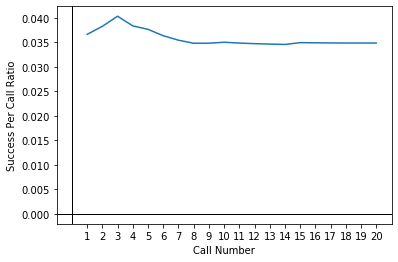

In [150]:
for k in persons_to_call_overall:
    if persons_to_call_overall[k]['n_rows'] == 956:
        thi_fs = k
        for res in persons_to_call_overall[k]['results']:
            print(res)
        plot_graph_new(persons_to_call_overall[k]['results'], 20, False, "")

In [151]:
res = construct_hull_points(combs_to_consider[thi_fs]['results'], max_calls)

In [153]:
thi_fs

(('secondary', 'primary'),
 ('unemployed',
  'admin.',
  'management',
  'self-employed',
  'technician',
  'unknown',
  'services',
  'housemaid',
  'blue-collar',
  'entrepreneur'),
 ('married', 'divorced'),
 ('no',),
 ('no',),
 ('yes',),
 ' balance > 450',
 'age >= 10 & age <= 34')

In [152]:
res

[0, 2, 4, 13, 14, 17, 19]

In [210]:
all_ed = ['primary', 'secondary', 'tertiary', 'unknown']
metric_vals = compute_metric_for_each_attribute(all_ed, train_df, 'education')
print(metric_vals)
print(len(all_combs)* len(age_query_strings) * len(balance_query_strings))

[[0.03163658]
 [0.04177496]
 [0.05546757]
 [0.05196893]]
384


In [18]:
print("Phase 5")
num_succ = 0
num_calls = 0

result_ratios_p5 = []
res_df = test_df.query("y == 'yes'")
print(len(res_df))
for i in range(1, 21):
    res_df2 = res_df.query("campaign == {0}".format(i))
    num_cust = len(res_df2)
    num_succ += num_cust
    num_calls = num_calls + (num_cust * i)
    result_ratios_p5.append((num_succ, num_calls))

res_df = test_df.query("y == 'no'")
print(len(res_df))
for i in range(1, 21):
    res_df2 = res_df.query("campaign == {0}".format(i))
    num_cust = len(res_df2)
    num_calls = num_calls + (num_cust * i)
    result_ratios_p5.append((num_succ, num_calls))
print(result_ratios_p5)

Phase 5
1060
7933
[(489, 489), (791, 1093), (920, 1480), (982, 1728), (1024, 1938), (1036, 2010), (1044, 2066), (1048, 2098), (1052, 2134), (1056, 2174), (1057, 2185), (1057, 2185), (1057, 2185), (1058, 2199), (1058, 2199), (1058, 2199), (1060, 2233), (1060, 2233), (1060, 2233), (1060, 2233), (1060, 5191), (1060, 9751), (1060, 12715), (1060, 15111), (1060, 16736), (1060, 18170), (1060, 19192), (1060, 20104), (1060, 20545), (1060, 21055), (1060, 21616), (1060, 21904), (1060, 22229), (1060, 22495), (1060, 22735), (1060, 22959), (1060, 23146), (1060, 23362), (1060, 23476), (1060, 23596)]


In [12]:
job_cmbs

[['unemployed',
  'admin.',
  'management',
  'self-employed',
  'technician',
  'unknown',
  'services',
  'housemaid',
  'blue-collar',
  'entrepreneur'],
 ['student', 'retired']]

In [96]:
optimal_choices

[((('secondary', 'primary'),
   ('student', 'retired'),
   ('married', 'single', 'divorced'),
   ('no',),
   ('no', 'yes'),
   ('no', 'yes'),
   'balance <= 450',
   'age >= 10 & age <= 34'),
  {'grad': 1.0,
   'loc': 5,
   'finished': True,
   'hull_points': [0, 1, 7, 18, 19],
   'max_num_pts': 4}),
 ((('secondary', 'primary'),
   ('student', 'retired'),
   ('married', 'single', 'divorced'),
   ('no',),
   ('no', 'yes'),
   ('no', 'yes'),
   ' balance > 450',
   'age >= 46'),
  {'grad': 0.3333333333333333,
   'loc': 7,
   'finished': False,
   'hull_points': [0, 1, 2, 5, 6, 8, 15, 16, 19],
   'max_num_pts': 8}),
 ((('tertiary', 'unknown'),
   ('unemployed',
    'admin.',
    'management',
    'self-employed',
    'technician',
    'unknown',
    'services',
    'housemaid',
    'blue-collar',
    'entrepreneur'),
   ('married', 'single', 'divorced'),
   ('yes', 'unknown'),
   ('no', 'yes'),
   ('no', 'yes'),
   'balance <= 450',
   'age >= 10 & age <= 34'),
  {'grad': 0.0,
   'loc': 4

In [92]:
result_ratios_p2

[(0, 0),
 (13, 117),
 (30, 252),
 (52, 402),
 (109, 873),
 (109, 877),
 (124, 998),
 (127, 1010),
 (136, 1086),
 (136, 1087),
 (143, 1186),
 (243, 2608),
 (245, 2633),
 (313, 3815),
 (329, 4158),
 (430, 5709),
 (522, 7508),
 (584, 8825),
 (682, 11137),
 (682, 11137),
 (728, 12398),
 (822, 14784),
 (899, 17500),
 (932, 18432),
 (933, 18447),
 (933, 18462),
 (935, 18506),
 (999, 20432),
 (999, 20479),
 (1065, 23392),
 (1069, 23505),
 (1070, 23555),
 (1072, 23665),
 (1073, 23700),
 (1075, 23802)]

In [77]:
num_calls

23802

In [53]:
for ch in optimal_choices:
    print(optimal_choices[ch]['grad'])

0.0
0.2
0.2
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [118]:
housing_cmbs

[['no'], ['yes']]

In [58]:
key = (('secondary', 'primary'),
  ('student', 'retired'),
  ('married', 'single', 'divorced'),
  ('no',),
  ('no', 'yes'),
  ('no',),
  'balance <= 450',
  'age >= 10 & age <= 34')
fs_pick[key]['loc'] = 0
fs_pick[key]['finished'] = False
print(fs_pick[key]['hull_points'])
total_s = 0
total_c = 0


[0, 4, 5, 10, 18, 19]


In [64]:
fs = fs_pick[key]
fs_results = combs_to_consider[key]['results']
hull_pts = fs['hull_points']
loc = fs['loc']
max_loc = fs['max_num_pts']
grad = 0.0
if loc <= max_loc:
    if loc == 0:
        grad = div(fs_results[hull_pts[loc]]['succ'], fs_results[hull_pts[loc]]['total_calls'])
    else:
        grad = div(fs_results[hull_pts[loc]]['succ'] - fs_results[hull_pts[loc-1]]['succ'] , fs_results[hull_pts[loc]]['total_calls'] - fs_results[hull_pts[loc-1]]['total_calls'])
    fs_pick[key]['grad'] = grad
else:
    fs_pick[key]['finished'] = True
print("At Loc:", loc)
print(grad)


fs = fs_pick[key]
if fs['finished'] == False:
    loc = fs['loc']
    if loc == 0:
        call_start = 1
        call_end = fs['hull_points'][loc] + 1
    else:
        call_start = fs['hull_points'][loc-1] + 2
        call_end = fs['hull_points'][loc] + 1
    print("Start and end:", call_start, call_end)
    for call in range(call_start, call_end + 1, 1):
        for loc, row in combs_to_consider[key]['fs_customers'].iterrows():
            if row['campaign'] == call:
                total_c += 1
                if row['y'] == "yes":
                    total_s += 1
            elif row['campaign'] > call:
                total_c += 1
    fs_pick[key]['loc'] += 1
print(total_s, total_c)

At Loc: 5
1.0
Start and end: 20 20
7 41


In [39]:
a = (('tertiary', 'unknown'), ('student', 'retired'), ('married', 'single', 'divorced'), ('no', 'yes'), ('no', 'yes'), ('yes', 'unknown'), 'balance <= 450', 'age >= 10 & age <= 34')
del combs_to_consider[a]

no 1
no 1
no 2
no 3
yes 1
no 5
no 1
no 3
no 1
no 1
no 1
no 1
yes 2
yes 1
yes 2
yes 1
yes 1
yes 3
no 1
no 3
no 3
no 1
no 2
{'grad': 1.0, 'loc': 6, 'finished': False, 'hull_points': [0, 4, 5, 10, 18, 19], 'max_num_pts': 5}


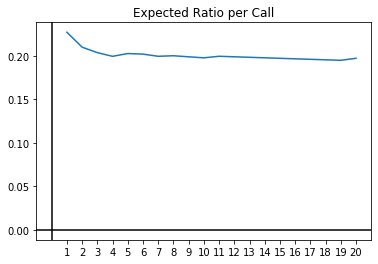

[{'succ': 37, 'total_calls': 163, 'expected': 0.22699386503067484}, {'succ': 51, 'total_calls': 243, 'expected': 0.20987654320987653}, {'succ': 57, 'total_calls': 280, 'expected': 0.20357142857142857}, {'succ': 60, 'total_calls': 301, 'expected': 0.19933554817275748}, {'succ': 64, 'total_calls': 316, 'expected': 0.20253164556962025}, {'succ': 65, 'total_calls': 322, 'expected': 0.20186335403726707}, {'succ': 65, 'total_calls': 326, 'expected': 0.19938650306748465}, {'succ': 66, 'total_calls': 330, 'expected': 0.2}, {'succ': 66, 'total_calls': 332, 'expected': 0.19879518072289157}, {'succ': 66, 'total_calls': 334, 'expected': 0.19760479041916168}, {'succ': 67, 'total_calls': 336, 'expected': 0.19940476190476192}, {'succ': 67, 'total_calls': 337, 'expected': 0.19881305637982197}, {'succ': 67, 'total_calls': 338, 'expected': 0.19822485207100593}, {'succ': 67, 'total_calls': 339, 'expected': 0.1976401179941003}, {'succ': 67, 'total_calls': 340, 'expected': 0.19705882352941176}, {'succ': 67

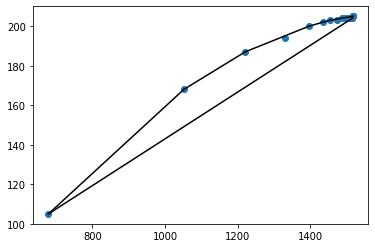

In [65]:
# key = (('secondary', 'primary'), ('unemployed', 'admin.', 'management', 'self-employed', 'technician', 'unknown', 'services', 'housemaid', 'blue-collar', 'entrepreneur'), ('married', 'single', 'divorced'), ('no',), ('no', 'yes'), ('yes', 'unknown'), 'balance <= 450', 'age >= 35 & age <= 45')
key = (('secondary', 'primary'),
  ('student', 'retired'),
  ('married', 'single', 'divorced'),
  ('no',),
  ('no', 'yes'),
  ('no',),
  'balance <= 450',
  'age >= 10 & age <= 34')
for index, row in combs_to_consider[key]['fs_customers'].iterrows():
    print(row['y'], row['campaign'])
print(fs_pick[key])
plot_graph_new(combs_to_consider[key]['results'], max_calls, False, "Expected Ratio per Call")
print(combs_to_consider[key]['results'])
res = construct_hull_points(combs_to_consider[fs_key]['results'])

In [34]:
num_s = 0
num_c = 0
for i, row in test_df.iterrows():
    if row['y'] == "yes":
        num_s += 1
    num_c += row['campaign']
print(num_s, num_c)

998 24293


In [33]:
num_s = 0
num_c = 0
for key in combs_to_consider.keys():
    for i, row in combs_to_consider[key]['fs_customers'].iterrows():
        if row['y'] == "yes":
            num_s += 1
        num_c += row['campaign']
print(num_s, num_c)

997 24290


# The cells that follow are used for checking/fine tuning purposes.

In [ ]:
age = 45
for age_q in age_query_strings:
    if eval(age_q):
        print("Yes!")
        print(age_q)

## Age and balance computation.

In [203]:
# Age.
# all_age_query_strings = ['age >= 10 & age <= 32', 'age >= 33 & age <= 40', 'age >= 50 & age <= 59', 'age >= 60']
# all_age_query_strings = ['age >= 10 & age <= 34', 'age >= 35 & age <= 45', 'age >= 46']
# all_age_query_strings = ['age < 26','age >= 26 & age <=60','age >60']
all_age_query_strings = ['age >= 10 & age <= 34', 'age >= 35 & age <= 45', 'age >= 46']
for age_query in all_age_query_strings:
    df_filtered_final = mkt_df_filtered.query(age_query)
    s = 0
    c = 0
    for index, row in df_filtered_final.iterrows():
        if row['y'] == "yes":
            s += 1
        c += row['campaign']
    print(s/c)
    print(df_filtered_final.shape)
    print(age_query)

0.05270867735577691
(14922, 10)
age >= 10 & age <= 34
0.035826210826210826
(15653, 10)
age >= 35 & age <= 45
0.046571295288446585
(14392, 10)
age >= 46


In [201]:
# Age.
all_age_query_strings = ['age >= 10 & age <= 19', 'age >= 20 & age <= 29', 'age >= 30 & age <= 39', 'age >= 40 & age <= 49', 'age >= 50 & age <= 59','age >= 60 & age <= 69', 'age >= 70 & age <= 79', 'age >= 80 & age <= 89', 'age >= 90 & age <= 100']
all_age_query_strings = ['age >= 10 & age <= 34', 'age >= 35 & age <= 45', 'age >= 46']
# age_query_strings = ['age >= 10 & age <= 33', 'age >= 34 & age <= 45', 'age >= 46']
for age_query in all_age_query_strings:
    df_filtered_final = mkt_df_filtered.query(age_query)
    print(df_filtered_final.shape[0])
    print(age_query, len(df_filtered_final), compute_metric(df_filtered_final))

14922
age >= 10 & age <= 34 14922 0.05270867735577691
15653
age >= 35 & age <= 45 15653 0.035826210826210826
14392
age >= 46 14392 0.046571295288446585


In [198]:
# Age
all_age_query_tuples = [(10, 20), (20, 30), (30, 40), (50, 60), (60, 70), (70, 80), (80, 90), (90, 100)]
ratios, all_age_query_strings = compute_metric_for_each_attribute_range(all_age_query_tuples, mkt_df_filtered, 'age')
print(ratios)
# find_combinations(all_age_query_strings, ratios)

[[0.14634146]
 [0.07631601]
 [0.04009731]
 [0.0343739 ]
 [0.12427647]
 [0.20594966]
 [0.19354839]
 [0.20588235]]


## ---------------------------------------------------------------------------------

In [219]:
# Balance
all_bal_query_strings = ['balance >= -100000 & balance <= -1', 'balance >= 0 & balance < 1000', 'balance >= 1000 & balance < 2000', 'balance >= 2000 & balance < 3000', 'balance >= 3000 & balance < 4000','balance >= 4000 & balance < 5000', 'balance >= 5000 & balance < 6000', 'balance >= 6000 & balance < 7000', 'balance >= 7000 & balance < 8000', 'balance >= 8000 & balance < 9000', 'balance >= 9000 & balance < 10000','balance >= 10000 & balance < 11000', 'balance >= 11000 & balance < 12000', 'balance >= 12000 & balance < 13000', 'balance >= 13000 & balance < 14000', 'balance >= 14000 & balance < 15000', 'balance >= 15000 & balance < 16000', 'balance >= 16000 & balance < 17000','balance >= 17000 & balance < 18000', 'balance >= 18000 & balance < 19000', 'balance >= 19000 & balance < 19000', 'balance >= 20000']
all_bal_query_strings = ['balance >= -100000 & balance <= -1', 'balance >= 0 & balance <= 2000', 'balance > 2000 & balance <= 4000', 'balance > 4000 & balance <= 6000', 'balance > 6000 & balance <= 8000', 'balance > 8000 & balance <= 10000', 'balance > 10000 & balance <= 12000', 'balance > 12000 & balance <= 14000', 'balance > 14000 & balance <= 16000', 'balance > 16000 & balance <= 18000', 'balance > 18000 & balance <= 20000' , 'balance >= 20000']
all_bal_query_strings = ['balance >= -100000 & balance <= -1', 'balance >= 0 & balance <= 5000', 'balance > 5000 & balance <= 10000', 'balance > 10000 & balance <= 15000','balance > 15000 & balance <= 20000', 'balance >20000']
for bal_query in all_bal_query_strings:
    df_filtered_final = mkt_df_filtered.query(bal_query)
    print(bal_query, len(df_filtered_final), compute_metric(df_filtered_final))

balance >= -100000 & balance <= -1 3731 0.020823004462072386
balance >= 0 & balance <= 5000 38403 0.04591801345633627
balance > 5000 & balance <= 10000 2007 0.05935984481086324
balance > 10000 & balance <= 15000 476 0.07851596203623813
balance > 15000 & balance <= 20000 158 0.03496503496503497
balance >20000 192 0.05742574257425743


In [ ]:
# Balance
all_bal_query_tuples = [(-10000, 0), (0, 250), (250, 500), (500, 750), (750,1000), (1000, 2000), (2000, 3000), (3000, 4000), (4000, 5000), (5000, 6000), (6000, 7000), (8000, 100000)]
ratios, all_bal_query_strings = compute_metric_for_each_attribute_range(all_bal_query_tuples, train_df, 'balance')
find_combinations(all_bal_query_strings, ratios)

## Determining where to stop regarding the number of calls.

In [ ]:
# This is to determine the maximum number of calls we should stop at!
all_ratios_calls = []
for i in range(1,57):
    query_str = 'campaign == ' + str(i)
    call_query_data = mkt_df_filtered.query(query_str)
    succ = 0
    calls = 0
    for lc, rw in call_query_data.iterrows():
        if rw['y'] == "yes":
            succ += 1
        calls += rw['campaign']
    all_ratios_calls.append(div(succ, calls))
for index, value in enumerate(all_ratios_calls):
    print(index+1, value)
plot_graph_new(all_ratios_calls, 56, True)

## Improving the success rate by optimizing the maximum calls made.

In [ ]:
mkt_df_filtered.head()

In [ ]:
max_calls_considered = 20

current_dir = os.getcwd()
mkt_df = load_file(current_dir + '/bank-full.csv')
mkt_df_filtered = mkt_df[(mkt_df['campaign']>=1) & (mkt_df['campaign']<=max_calls_considered)]

result_ratios = [0.0 for i in range (1,max_calls_considered+1)]

for i in range(1, max_calls_considered+1):
    total_calls = 0
    total_succ = 0
    #query_str = "campaign <= {0}".format(i)
    #print(query_str)
    #df_filtered_campaign = mkt_df_filtered.query(query_str)
    for loc, row in mkt_df_filtered.iterrows():
        if row['y']  == "yes" and row['campaign'] <= i:
            total_succ += 1
        total_calls += min(i, row['campaign'])
    result_ratios[i-1] = div(total_succ , total_calls)
    print(i, result_ratios[i-1], total_succ, total_calls)

In [ ]:
plot_graph_new(result_ratios, 20, True, "Ratio Per Call #")

In [ ]:
current_dir = os.getcwd()
mkt_df = load_file(current_dir + '/bank-full.csv')
mkt_df_filtered = mkt_df[(mkt_df['campaign']>=1) & (mkt_df['campaign']<=max_calls)]
mkt_df_filtered.shape

In [ ]:
mkt_df_filtered.head(n=10)

In [ ]:
mkt_df_filtered['poutcome'].value_counts()

In [ ]:
mkt_df_filtered_successes = mkt_df_filtered.query("poutcome == 'success'")
print(mkt_df_filtered_successes.shape)
mkt_df_filtered_successes['previous'].value_counts()

In [ ]:
mkt_df_filtered_successes['poutcome'].value_counts()

In [ ]:
res = mkt_df_filtered_successes['campaign'].value_counts(normalize = False)
print(res)
print(res.values)
num_succ = [2561, 1401 , 618, 317, 139, 92, 47, 32, 21, 14, 16, 4, 6, 4, 4, 2, 6, 0, 0 ,1]

In [ ]:
plot_graph_new(num_succ, 20, True, "Frequency of Contacts Made per Call #")

In [ ]:
a = mkt_df_filtered.query("y == 'yes'").shape[0]
b = mkt_df_filtered.query("poutcome == 'success'").shape[0]
anb = mkt_df_filtered.query("y == 'yes' and poutcome == 'success'").shape[0]
print(anb/b)

In [ ]:
for i in range(0, 4920, 60):
    res = mkt_df_filtered.query("duration >= {0} and duration <= {1}".format(str(i-60), str(i)))
    print(i, res.shape[0], res.query("y == 'yes'").shape[0])
# a = mkt_df_filtered.query("duration >= 0 and duration <= 180").shape[0]
# b = mkt_df_filtered.query("y == 'yes'").shape[0]
# anb = mkt_df_filtered.query("y == 'yes' and duration >= 0 and duration <= 1000").shape[0]
# print(anb/b)

In [ ]:
# int(mkt_df_filtered['duration'].max()/60)+1
int(mkt_df_filtered['duration'].max()/60) + 1

In [ ]:
a = mkt_df_filtered.query("y == 'yes' and contact == 'cellular'").shape[0]
b = mkt_df_filtered.query("y == 'yes' and contact == 'telephone'").shape[0]
c = mkt_df_filtered.query('y == "yes"').shape[0]
print(a, b, c)

## Irritability

In [4]:
succ_ratios = []
for i in range(1,21):
    num_calls = 0
    num_succ = 0
    for loc, row in mkt_df_filtered.iterrows():
        if row['campaign'] <= i:
            num_calls += row['campaign']
            if row['y'] == "yes":
                num_succ += 1
    succ_ratios.append(div(num_succ, num_calls))
succ_ratios

[0.14597583219334245,
 0.093105231000611,
 0.07747348478441057,
 0.06689433781845502,
 0.06139591587930509,
 0.057123124394292145,
 0.054521893042268954,
 0.05247087750413156,
 0.05116511220505192,
 0.050000476921756215,
 0.04911723493694535,
 0.04831512257827564,
 0.04761431321685843,
 0.0470962381969073,
 0.04660736212577627,
 0.04611016467915957,
 0.04569432193569588,
 0.04533443151789698,
 0.045011585116532644,
 0.04469269018705815]

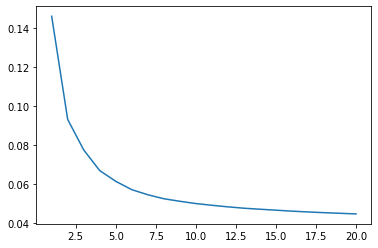

In [8]:
plt.plot([i for i in range (1,21)], succ_ratios)

In [8]:
time_taken_all = []
successes_all = []
for i in range(1,21):
    time_taken = 0
    num_succ = 0
    num_ppl = 0
    for loc, row in mkt_df_filtered.iterrows():
        num_ppl += 1
        if row['campaign'] <= i:
            time_taken += int(row['duration'])
            if row['y'] == "yes":
                num_succ += 1
    time_taken_all.append(time_taken/num_ppl)
    # successes_all.append(num_succ)

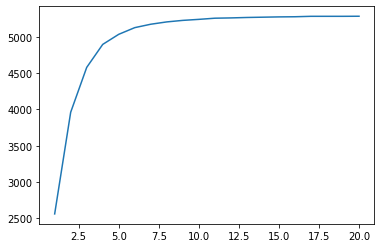

In [16]:
plt.plot([i for i in range(1,21)], successes_all)
plt.show()

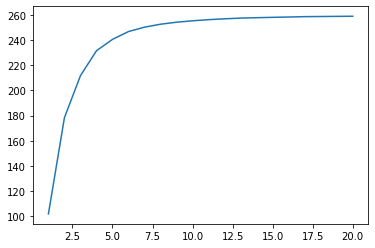

In [9]:
plt.plot([i for i in range(1,21)], time_taken_all)

In [10]:
time_taken_all

[101.85080169902373,
 178.4169946849912,
 211.76851913625546,
 231.59975092845866,
 240.6439833655792,
 246.87644272466474,
 250.36371116596615,
 252.6973336001957,
 254.29739586808103,
 255.4163052905464,
 256.31912291235795,
 257.00015566971337,
 257.5572530967154,
 257.88017879778505,
 258.170080281095,
 258.4242666844575,
 258.72288567171483,
 258.82662841639427,
 258.93866613294193,
 259.03891742833633]

In [19]:
time_taken_all

[4579925,
 8022877,
 9522595,
 10414346,
 10821038,
 11101293,
 11258105,
 11363041,
 11434991,
 11485305,
 11525902,
 11556526,
 11581577,
 11596098,
 11609134,
 11620564,
 11633992,
 11638657,
 11643695,
 11648203]

In [21]:
new_succ = [0 for i in range(1,21)]
new_succ[0] = successes_all[0]
for i in range(1,20):
    new_succ[i] = successes_all[i] - successes_all[i-1]
new_succ

[2561, 1401, 618, 317, 139, 92, 47, 32, 21, 14, 16, 4, 6, 4, 4, 2, 6, 0, 0, 1]

In [23]:
new_dur = [0 for i in range(1,21)]
new_dur[0] = time_taken_all[0]
for i in range(1,20):
    new_dur[i] = time_taken_all[i] - time_taken_all[i-1]
for i in range(0,20):
    new_dur[i] /= 60
new_dur

[76332.08333333333,
 57382.53333333333,
 24995.3,
 14862.516666666666,
 6778.2,
 4670.916666666667,
 2613.5333333333333,
 1748.9333333333334,
 1199.1666666666667,
 838.5666666666667,
 676.6166666666667,
 510.4,
 417.51666666666665,
 242.01666666666668,
 217.26666666666668,
 190.5,
 223.8,
 77.75,
 83.96666666666667,
 75.13333333333334]

In [30]:
time_taken_all = []
successes_all = []

for i in range(1,21):
    time_taken = 0
    num_succ = 0
    for loc, row in mkt_df_filtered.iterrows():
        if row['campaign'] == i:
            time_taken += int(row['duration']/60)
            if row['y'] == "yes":
                num_succ += 1
    time_taken_all.append(time_taken)
    successes_all.append(num_succ)


In [25]:
time_taken_all

[67743,
 51246,
 22317,
 13154,
 5947,
 4084,
 2260,
 1489,
 1041,
 709,
 584,
 443,
 360,
 201,
 179,
 159,
 196,
 57,
 68,
 58]

In [31]:
successes_all

[2561,
 3962,
 4580,
 4897,
 5036,
 5128,
 5175,
 5207,
 5228,
 5242,
 5258,
 5262,
 5268,
 5272,
 5276,
 5278,
 5284,
 5284,
 5284,
 5285]

In [32]:
res = []
for i in range(0,20):
    res.append(div(successes_all[i],time_taken_all[i]))
res

[0.0378046440222606,
 0.033297195539083446,
 0.03241192872206417,
 0.03170400103586689,
 0.03139513861614518,
 0.031174957900432242,
 0.031034296645897175,
 0.030949833571088922,
 0.03088356047046036,
 0.030837108065180304,
 0.030825330941409594,
 0.03076887093096008,
 0.030739247390256567,
 0.03072655002389584,
 0.030717816449984572,
 0.030701040042811607,
 0.03070093892349168,
 0.030690774762007097,
 0.03067865789580636,
 0.030674134478655794]

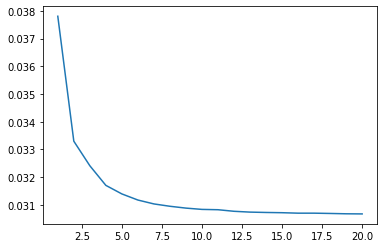

In [35]:
plt.plot([i for i in range(1,21)], res)

In [ ]:
# BACKUP

%%time

# Main code ... orchestrates everything!

# Splitting dataframe into data and result dataframes.
X = mkt_df_filtered.iloc[:,0:len(mkt_df_filtered.columns)-1]
y = mkt_df_filtered.iloc[:,-1]

cut_points = [0]

for cp in cut_points:

    for j in range(1,2):
        
        phase_batch = {}
        kf = KFold(n_splits=5, shuffle=True)
        i = 0
        for train_index, test_index in kf.split(X):
            i += 1

            train_df = mkt_df_filtered.iloc[train_index]
            test_df = mkt_df_filtered.iloc[test_index]

            # At this point, we can run computations for the success rate of each sub attribute and join
            # the sub-attributes based on the output of k-means.
            poss = []

            # Education.
            all_ed = ['tertiary', 'secondary', 'primary', 'unknown']
            metric_vals = compute_metric_for_each_attribute(all_ed, train_df, 'education')
            education_cmbs = find_combinations(all_ed, metric_vals)

            # Occupation.
            all_jobs = ['student', 'retired', 'unemployed', 'admin.', 'management', 'self-employed', 'technician', 'unknown', 'services', 'housemaid', 'blue-collar', 'entrepreneur']
            metric_vals = compute_metric_for_each_attribute(all_jobs, train_df, 'job')
            job_cmbs = find_combinations(all_jobs, metric_vals)

            # Marital.
            all_ms = ['married', 'single', 'divorced', 'unknown']
            metric_vals = compute_metric_for_each_attribute(all_ms, train_df, 'marital')
            marital_cmbs = find_combinations(all_ms, metric_vals)

            # Default
            all_def = ['no', 'yes', 'unknown']
            metric_vals = compute_metric_for_each_attribute(all_def, train_df, 'default')
            default_cmbs = find_combinations(all_def, metric_vals)

            # Loan
            all_ln = ['no', 'yes', 'unknown']
            metric_vals = compute_metric_for_each_attribute(all_ln, train_df, 'loan')
            loan_cmbs = find_combinations(all_ln, metric_vals)

            # Housing
            all_hs = ['no', 'yes', 'unknown']
            metric_vals = compute_metric_for_each_attribute(all_hs, train_df, 'housing')
            housing_cmbs = find_combinations(all_hs, metric_vals)

            poss.append(education_cmbs)
            poss.append(marital_cmbs)
            poss.append(job_cmbs)
            poss.append(default_cmbs)
            poss.append(loan_cmbs)
            poss.append(housing_cmbs)
            all_combs = list(itertools.product(*poss))

            # print("Number of combinations: ", len(all_combs)* len(age_query_strings) * len(balance_query_strings))

            # We can now go ahead and genreate the feature sets based on what was done previously.
            num_iter = 0
            combs_to_consider = {}
            fs_pick = {}

            # Setting up looping structures to generate all possibilities.
            for age_query in age_query_strings:
                df_filtered_final = train_df.query(age_query)
                for bal_query in balance_query_strings:
                    df_filtered_final_2 = df_filtered_final.query(bal_query)
                    for comb in all_combs:
                        dict_final_query = construct_dict(comb)
                        num_iter += 1
                        extracted_df = extract_rows_feature_set(df_filtered_final_2, dict_final_query)
                        key = (dict_final_query['education'], dict_final_query['job'], 
                               dict_final_query['marital'], dict_final_query['default'], 
                               dict_final_query['loan'], dict_final_query['housing'], 
                               bal_query, age_query)
                        n_rows = extracted_df.shape[0]
                        if n_rows > cp:
                            results = compute_expected_succ_per_call_rate_feature_set(extracted_df, max_calls)
                            max_loc = compute_optimal_call_no(results)
                            if max_loc != -1:
                                combs_to_consider[key] = {
                                                            'max_loc':max_loc + 1,
                                                            'best_rate':results[max_loc]['expected'], 
                                                            'overall_rate':results[max_calls-1]['expected'], 
                                                            'n_rows':n_rows, 
                                                            'results':results,
                                                            'fs_customers':None,
                                                            'valid': True
                                                         }
                                fs_pick[key] = {'current_ratio': 0.0, 'call_num':0, 'finished':False}
                            else:
                                print("Invalid FS ! -> ", n_rows)
            
            for fs_key in combs_to_consider.keys():
                fs_customers = find_all_cust_feature_set(fs_key, test_df)
                combs_to_consider[fs_key]['fs_customers'] = fs_customers

            
            # Testing Phase 1: Baseline test with shuffling of customers.

            call_check_points = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000, 13500, 14000, 14500, 15000, 15500, 16000, 16500, 17000, 17500, 18000, 18500, 19000, 19500, 20000, 20500, 21000, 21500, 22000, 22500, 23000, 23500, 24000, 24500, 25000, 25500, 26000, 26500, 27000, 27500, 28000, 28500, 29000, 29500, 30000, 30500, 31000, 31500, 32000, 32500, 33000, 33500, 34000, 34500, 35000, 35500, 36000, 36500, 37000, 37500, 38000, 38500, 39000, 39500, 40000, 40500, 41000, 41500, 42000, 42500, 43000, 43500, 44000, 44500, 45000, 45500, 46000, 46500, 47000, 47500, 48000, 48500, 49000, 49500, 50000, 50500, 51000, 51500, 52000, 52500, 53000, 53500, 54000, 54500, 55000, 55500, 56000, 56500, 57000, 57500, 58000, 58500, 59000, 59500, 60000, 60500, 61000, 61500, 62000, 62500, 63000, 63500, 64000, 64500, 65000, 65500, 66000, 66500, 67000, 67500, 68000, 68500, 69000, 69500, 70000, 70500, 71000, 71500, 72000, 72500, 73000, 73500, 74000, 74500, 75000, 75500, 76000, 76500, 77000, 77500, 78000, 78500, 79000, 79500, 80000, 80500, 81000, 81500, 82000, 82500, 83000, 83500, 84000, 84500, 85000, 85500, 86000, 86500, 87000, 87500, 88000, 88500, 89000, 89500, 90000, 90500, 91000, 91500, 92000, 92500, 93000, 93500, 94000, 94500, 95000, 95500, 96000, 96500, 97000, 97500, 98000, 98500, 99000, 99500, 100000, 100500, 101000, 101500, 102000, 102500, 103000, 103500, 104000, 104500, 105000, 105500, 106000, 106500, 107000, 107500, 108000, 108500, 109000, 109500, 110000, 110500, 111000, 111500, 112000, 112500, 113000, 113500, 114000, 114500, 115000, 115500, 116000, 116500, 117000, 117500, 118000, 118500, 119000, 119500, 120000, 120500, 121000, 121500, 122000, 122500, 123000, 123500, 124000, 124500, 125000, 125500, 126000, 126500, 127000, 127500, 128000, 128500, 129000, 129500, 130000, 130500, 131000, 131500, 132000, 132500, 133000, 133500, 134000, 134500, 135000, 135500, 136000, 136500, 137000, 137500, 138000, 138500, 139000, 139500]
            result_ratios_p1 = []
            cp_loc = 0
            num_succ = 0
            num_calls = 0
            res = test_df.reindex(np.random.permutation(test_df.index))
            for loc, row in res.iterrows():
                if num_calls >= call_check_points[cp_loc]:
                    cp_loc += 1
                    result_ratios_p1.append((num_succ, num_calls))
                num_calls += row['campaign']
                if row['y'] == "yes":
                    num_succ += 1
            result_ratios_p1.append((num_succ, num_calls))


            # Testing Phase 2: Order how we call customer based on the overall s/c ratio.
            # In this instance we call everyone.

            persons_to_call_overall = {k: v for k, v in sorted(combs_to_consider.items(), key=lambda fs: fs[1]['overall_rate'], reverse = True)}
            num_succ = 0
            num_calls = 0
            result_ratios_p2 = []
            # print(type(persons_to_call_overall))
            result_ratios = []
            for key in persons_to_call_overall.keys():
                for loc, cust in persons_to_call_overall[key]['fs_customers'].iterrows():
                    num_calls += cust['campaign']
                    if cust['y'] == "yes":
                        num_succ +=1
                result_ratios_p2.append((num_succ, num_calls))


            # Testing Phase 3: Order how we call customers based on the maximum s/c ratio.
            # The maximum s/c ratio is linked to a call number. Use this to determine number of successes.

#             persons_to_call_max = {k: v for k, v in sorted(combs_to_consider.items(), key=lambda fs: fs[1]['best_rate'], reverse = True)}
#             num_succ = 0
#             num_calls = 0
#             result_ratios_p3 = []
#             # print(type(persons_to_call_max))
#             result_ratios_p3 = []
#             for key in persons_to_call_max.keys():
#                 max_calls_fs = persons_to_call_max[key]['max_loc']
#                 for loc, cust in persons_to_call_max[key]['fs_customers'].iterrows():
#                     cust_calls = cust['campaign']
#                     if cust_calls <= max_calls_fs:
#                         num_calls += cust_calls
#                         if cust['y'] == "yes":
#                             num_succ +=1
#                     else:
#                         num_calls += max_calls_fs
#                 result_ratios_p3.append((num_succ, num_calls))


            # Testing Phase 4: Order how we call customers from feature sets.
            # Use the approach of calculating gradient at each call point and use this to order
            # how the calls are made.

            result_ratios_p4 = []
            total_s = 0
            total_c = 0

            for k in range(1,21):
                for key in combs_to_consider.keys():
                    fs_ref = combs_to_consider[key]['results']
                    pos = fs_pick[key]['call_num']
                    if pos < 20:
                        fs_pick[key]['call_num'] += 1
                        if pos == 0:
                            fs_pick[key]['current_ratio'] = div(fs_ref[pos]['succ'], fs_ref[pos]['total_calls'])
                        else:
                            fs_pick[key]['current_ratio'] = div((fs_ref[pos]['succ'] - fs_ref[pos-1]['succ']), (fs_ref[pos]['total_calls'] - fs_ref[pos-1]['total_calls']))
                    else:
                        fs_pick[key]['finished'] = True

                optimal_choices = {k: v for k, v in sorted(fs_pick.items(), key=lambda val: val[1]['current_ratio'], reverse = True)}

                for key in optimal_choices.keys():
                    if optimal_choices[key]['finished'] == False:
                        for loc, row in combs_to_consider[key]['fs_customers'].iterrows():
                            if row['campaign'] == (optimal_choices[key]['call_num']):
                                total_c += 1
                                if row['y'] == "yes":
                                    total_s += 1
                            elif row['campaign'] > (optimal_choices[key]['call_num']):
                                total_c += 1
                        result_ratios_p4.append((total_s, total_c, k))

#             result_ratios_p4 = []
#             total_s = 0
#             total_c = 0

#             for k in range(1,21):
#                 for key in combs_to_consider.keys():
#                     fs_ref = combs_to_consider[key]['results']
#                     # Sort of a patch to the results so subtracting would be easier.
#                     fs_ref.insert(0, {'succ':0, 'total_calls':0, 'expected':0.0})
#                     e_pos = fs_pick[key]['end'] # This should initially be 1
#                     s_pos = fs_pick[key]['end'] - 1 # This should initially be 0
#                     curr_ratio = 0.0
#                     if e_pos < 21:
#                         curr_ratio = div((fs_ref[e_pos]['succ'] - fs_ref[s_pos]['succ']), (fs_ref[e_pos]['total_calls'] - fs_ref[s_pos]['total_calls']))
#                         if curr_ratio != 0.0:
#                             e_pos += 1
#                             s_pos += 1
#                         else:
#                             while e_pos < 21 and curr_ratio == 0.0:
#                                 e_pos += 1
#                                 curr_ratio = div((fs_ref[e_pos]['succ'] - fs_ref[s_pos]['succ']), (fs_ref[e_pos]['total_calls'] - fs_ref[s_pos]['total_calls']))
#                         fs_pick[key]['end'] = e_pos
#                         fs_pick[key]['start'] = s_pos
#                         fs_pick[key]['current_ratio'] = curr_ratio
#                         if e_pos >= 21:
#                             fs_pick[key]['finished'] = True
#                     else:
#                         fs_pick[key]['finished'] = True

#                 optimal_choices = {k: v for k, v in sorted(fs_pick.items(), key=lambda val: val[1]['current_ratio'], reverse = True)}
# #                 print(optimal_choices)
#                 for key in optimal_choices.keys():
#                     if optimal_choices[key]['finished'] == False:
#                         start = optimal_choices[key]['start']
#                         end = optimal_choices[key]['end']
#                         for s in range(start, end, 1):
#                             for loc, row in combs_to_consider[key]['fs_customers'].iterrows():
#                                 if row['campaign'] == s:
#                                     total_c += 1
#                                     if row['y'] == "yes":
#                                         total_s += 1
#                                 elif row['campaign'] > s:
#                                     total_c += 1
#                         result_ratios_p4.append((total_s, total_c, k))
                    
            
            # Testing Phase 5: Using a Decision Tree.
            # Use the copy of the mkt dataframe for this portion.
            
#             result_ratios_p5 = []
#             total_succ = 0
#             total_calls = 0
#             cp_loc = 0
            
#             train_x = train_df_cpy.iloc[:,0:len(train_df_cpy.columns)-1]
#             train_y = train_df_cpy.iloc[:,-1]

#             test_x = test_df_cpy.iloc[:,0:len(test_df_cpy.columns)-1]
#             test_y = test_df_cpy.iloc[:,-1]
            
#             clf = DecisionTreeClassifier()
#             clf = clf.fit(train_x, train_y)
#             test_y_pred = clf.predict(test_x)
            
#             for index, outcome in enumerate(test_y_pred):
#                 num_calls_made = int(test_x.iloc[index]['campaign'])
#                 actual_result = int(test_y.iloc[index]) == 1
#                 if total_calls >= call_check_points[cp_loc]:
#                     cp_loc += 1
#                     result_ratios_p5.append((total_succ, total_calls))
#                 if outcome == 1:
#                     total_calls += num_calls_made
#                     if actual_result:
#                         total_succ += 1
#             result_ratios_p5.append((total_succ, total_calls))
            
            # Final Part .... Put results in dict and append to array.
            
            phase_batch_key = str(j) + "_" + str(i)
            phase_batch[phase_batch_key] = {'p1':result_ratios_p1, 'p2':result_ratios_p2, 'p4':result_ratios_p4}
            
    with open('idk_results_cp_' + str(cp) +'.json', 'w') as fp:
        json.dump(phase_batch, fp)

In [33]:
job_cmbs

[['unemployed',
  'admin.',
  'management',
  'self-employed',
  'technician',
  'unknown',
  'services',
  'housemaid',
  'blue-collar',
  'entrepreneur'],
 ['student', 'retired']]